In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dataproc.operations.hitp as hitpops
import pyFAI.detectors as dets
import pyFAI

from pathlib import Path

import glob

from importlib import reload
from dataproc.operations import hitp

In [78]:
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc/operations/hitp.py'>

In [79]:
df = pd.read_csv("YijinXRD.dat", sep = '\t')
qq = df.iloc[:, 0]

patterns = df.iloc[:, 2:]
patterns = patterns.values.T
for i in range(len(patterns)):
    patterns[i] = patterns[i] - i * 1000
    
x = np.arange(len(patterns[0])) + 1
y = patterns[0]
    
boundaries = hitp.bayesian_block_finder(x, y)

numBlocks: 352, dataPts/Block: 1.6988636363636365


In [80]:
import pdb

In [144]:
import time
import json
from pathlib import Path
import re
import pyFAI.detectors as dets
import numpy as np

from dataproc.operations import hitp

from dataproc.operations.hitp import (load_image, create_scan, save_Itth, save_qchi, 
                                integrate_1d_mg, fit_peak, save_dict, save_curve_fit, 
                                bkgd_sub, summarize_params)
from dataproc.operations.utils import single_select, folder_select
from scipy.ndimage.filters import gaussian_filter as gf

template = ''
configPath = "workflows/alanConfig"

# Configuration setup
# Grab configs
print(configPath)
with open(configPath) as jp:
    cfg = json.load(jp)
cfg['fitInfo']['blockBounds'] = boundaries


def alanWorkflow(y, boundaries, downsample_start = 0, downsample_end = -1):

    # Fill out experimental information
    expInfo = {}


    expInfo['blockBounds'] = cfg['fitInfo']['blockBounds']

    print('Experimental Info used: \n')
    print(expInfo)

    # Pull out Fit info
    fitInfo = cfg['fitInfo']

    # Start processing loop =======================================================
    run_enable = True
    
    # restrict range?
    subx, suby = np.arange(len(y)) + 1, y
    #pdb.set_trace()
    # Background subtract/move to zero
    suby = suby - np.min(suby)
    subx, suby = bkgd_sub(subx, suby, start = downsample_start, end = downsample_end)

    # segment rangeinto two...
    xList = []
    yList = []
    bnds = expInfo['blockBounds']
    for leftBnd in range(len(bnds) - 1): # indexes
        xList.append(subx[np.where((subx >= bnds[leftBnd]) & (subx < bnds[leftBnd + 1]))])
        yList.append(suby[np.where((subx >= bnds[leftBnd]) & (subx < bnds[leftBnd + 1]))])
    
    for xbit, ybit, i in zip(xList, yList, range(len(xList))):
        # Restrict range and fit peaks
        curveParams, derivedParams = fit_peak(xbit, ybit,
                            peakShape=fitInfo['peakShape'],
                            fitMode=fitInfo['fitMode'],
                            numCurves=fitInfo['numCurves'])
        print(f'    ----Saving data for block between {np.min(xbit):.2f} - {np.max(xbit):.2f}')
        # output/saving of blocks
        save_dict(curveParams, cfg['exportPath'], template + f'_block{i}_curve')
        save_dict(derivedParams, cfg['exportPath'], template + f'_block{i}_derived')
        save_curve_fit(xbit, ybit, curveParams, cfg['exportPath'], 
                        template + f'_block{i}', peakShape=fitInfo['peakShape'])
    return suby

def bgsub(y, npad = 10, boundaries_min = 30, boundaries_max = 598 + 30):
    boundaries = hitp.bayesian_block_finder(x, gf(y, 1.5)) + npad
    #boundaries = [b for b in boundaries if b >= boundaries_min and b <= boundaries_max]
    print(boundaries)
    cfg['fitInfo']['blockBounds'] = boundaries
    if npad != 0:
        y = np.pad(y, npad, mode= 'edge')
    suby = alanWorkflow(y, boundaries)
    if npad != 0:
        suby = suby[npad:-npad]
    return suby

workflows/alanConfig


In [121]:
patterns.shape

(60, 598)

In [5]:
%pdb

Automatic pdb calling has been turned ON


In [24]:
%matplotlib notebook

<IPython.core.display.Javascript object>


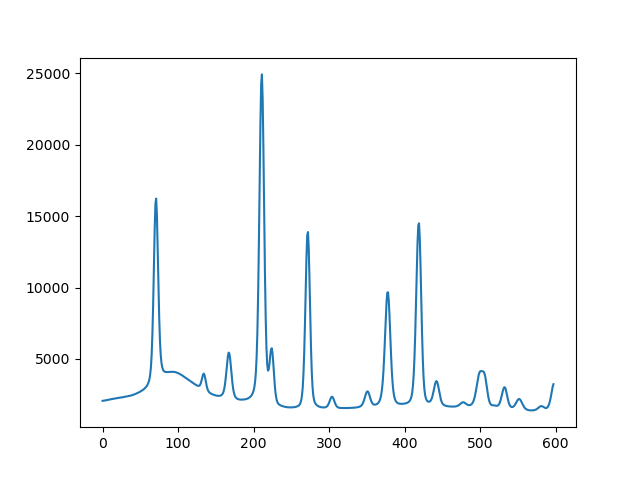

In [36]:
plt.plot(gf(patterns[41], 1.5))

In [125]:
hitp.bayesian_block_finder(x, gf(patterns[20], 1.5))

numBlocks: 392, dataPts/Block: 1.5255102040816326


array([  0.,  32., 126., 171., 227., 260., 301., 347., 406., 425., 445.,
       491., 533., 597.])

In [158]:
i = 51

In [159]:
y3 = bgsub(patterns[i], npad = 20)

numBlocks: 412, dataPts/Block: 1.4514563106796117
[ 20.  99. 144. 170. 198. 210. 235. 270. 315. 335. 374. 406. 448. 480.
 501. 515. 529. 554. 578. 598. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  99., 144., 170., 198., 210., 235., 270., 315., 335., 374.,
       406., 448., 480., 501., 515., 529., 554., 578., 598., 617.])}
Peak at 90, start iteration with error = 0.34735946252178673
Peak at 90, iteration 0: error = 0.6286705500942096
Peak at 90, iteration 1: error = 0.06500684058947
Peak at 90, iteration 2: error = 0.06500684059697992
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 20.00 - 98.00
Peak at 112, start iteration with error = 0.3045741286623806
Peak at 112, iteration 0: error = 0.6935574828693665
Peak at 112, iteration 1: error = 0.01984200692695985
Peak at 112, iteration 2: error = 0.008952447872028937
    ----Saving data for block between 99.00 - 143.00
Peak at 154, start iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 501.00 - 514.00
Peak at 519, start iteration with error = 0.5234941881281511
Peak at 519, iteration 0: error = 0.46909388850754835
Peak at 519, iteration 1: error = 0.021620917154011213
Peak at 519, iteration 2: error = 0.01768212587862401


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 515.00 - 528.00
Peak at 546, start iteration with error = 0.3138586055619538
Peak at 546, iteration 0: error = 0.6801993972288943
Peak at 546, iteration 1: error = 0.03379739133201399
Peak at 546, iteration 2: error = 0.021811894171047626
    ----Saving data for block between 529.00 - 553.00
Peak at 563, start iteration with error = 0.3033167573803938
Peak at 563, iteration 0: error = 0.6686881775264336
Peak at 563, iteration 1: error = 0.06690183856679538
Peak at 563, iteration 2: error = 0.04922892394244666
    ----Saving data for block between 554.00 - 577.00
Peak at 594, start iteration with error = 0.3481470165134366
Peak at 594, iteration 0: error = 0.638549628240691
Peak at 594, iteration 1: error = 0.04539267328470996
Peak at 594, iteration 2: error = 0.028736031774456456
    ----Saving data for block between 578.00 - 597.00
Peak at 611, start iteration with error = 0.5564492419640062
Peak at 611, iteration 0: error = 0.4325651593838197
Pea

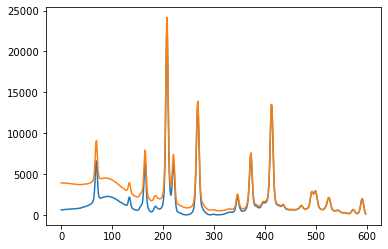

In [160]:
plt.plot(y3)
plt.plot(bgsubbed[i])

array([20, 23, 24, 18, 19, 28, 17, 25, 53, 30, 14,  2, 12, 59, 32, 29,  8,
       58, 31, 43, 38, 34, 26,  4, 35,  1,  3, 33,  7, 36, 57, 27, 41, 37,
       45, 39, 48, 11,  5, 46, 10, 54, 44, 15, 49, 51, 52,  0, 56, 16, 13,
       55,  9, 42, 22,  6, 47, 40, 21, 50])

numBlocks: 392, dataPts/Block: 1.5255102040816326
Experimental Info used: 

{'blockBounds': array([  0.,  32., 126., 171., 227., 260., 301., 347., 406., 425., 445.,
       491., 533., 597.])}
Peak at 1, start iteration with error = 0.7389041728549444
Peak at 1, iteration 0: error = 2.6423993974768996
Peak at 1, iteration 1: error = 0.7283405613127885
Peak at 1, iteration 2: error = 0.7281887728523846
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 31.00


<IPython.core.display.Javascript object>


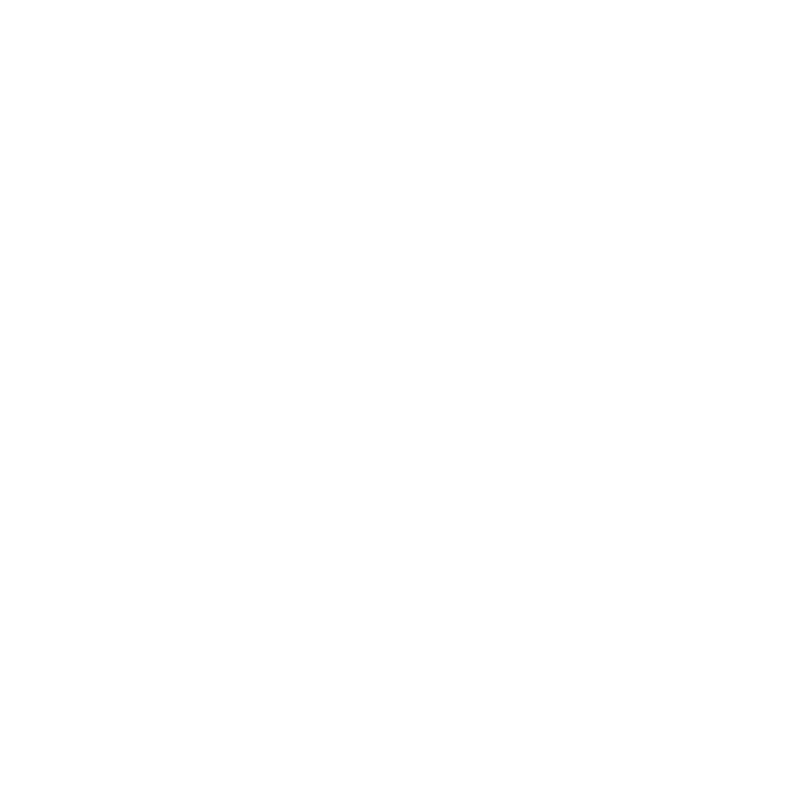

Peak at 70, start iteration with error = 0.9351432367406477
Peak at 70, iteration 0: error = 2.015825087649029
Peak at 70, iteration 1: error = 0.27667868605099083
Peak at 70, iteration 2: error = 0.33467494734926484
    ----Saving data for block between 32.00 - 125.00


<IPython.core.display.Javascript object>


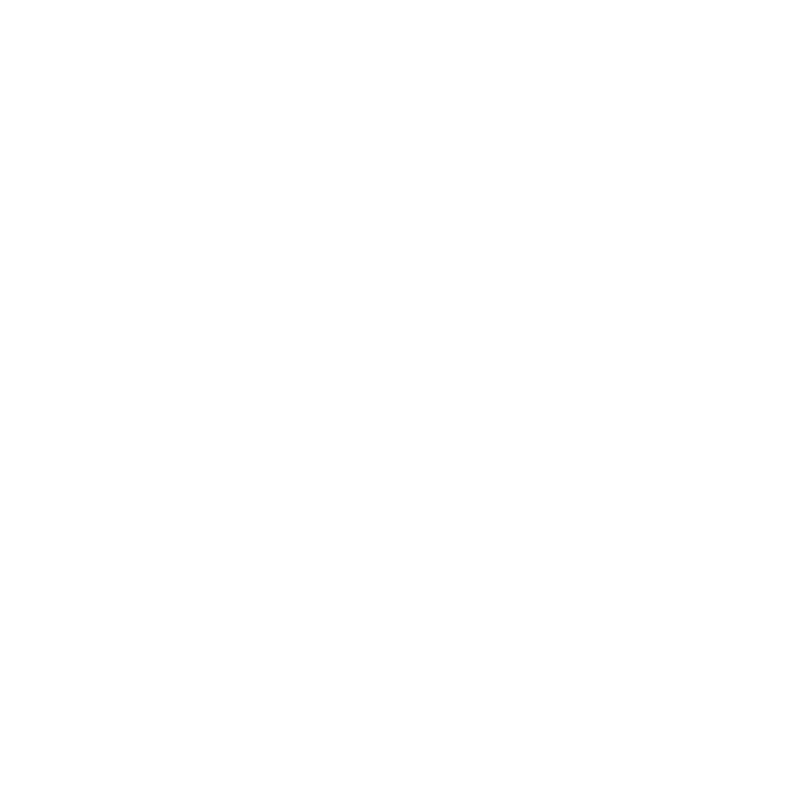

Peak at 137, start iteration with error = 0.41488522970897185
Peak at 137, iteration 0: error = 0.538882648025574
Peak at 137, iteration 1: error = 0.06744143156055941
Peak at 137, iteration 2: error = 0.08116311899714007
    ----Saving data for block between 126.00 - 170.00


<IPython.core.display.Javascript object>


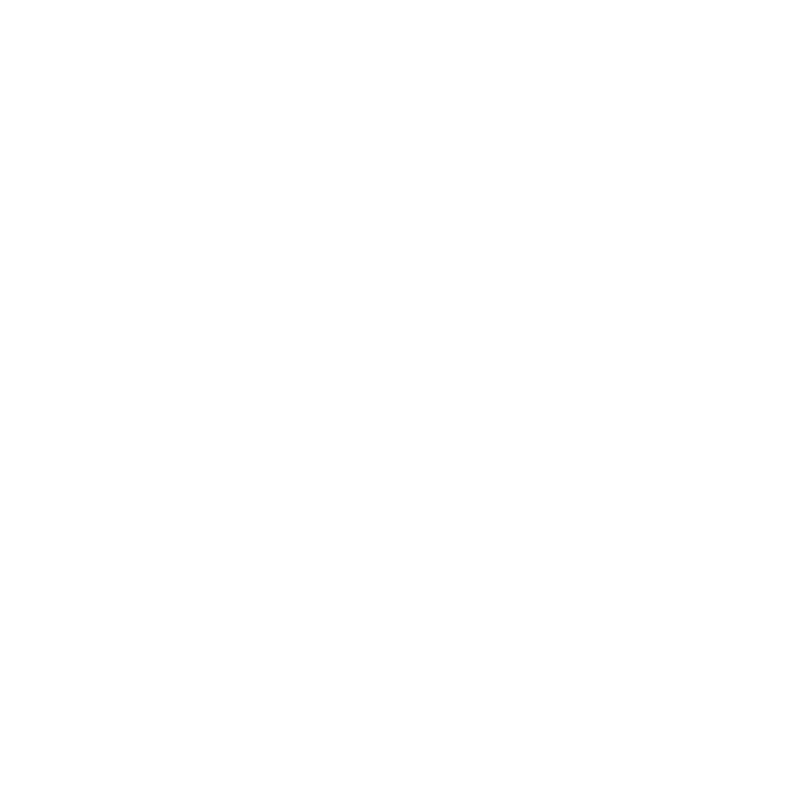

Peak at 221, start iteration with error = 0.47696921800814795
Peak at 221, iteration 0: error = 0.3819435283216886
Peak at 221, iteration 1: error = 0.03578474557923172
Peak at 221, iteration 2: error = 0.035784742834869036
    ----Saving data for block between 171.00 - 226.00


<IPython.core.display.Javascript object>


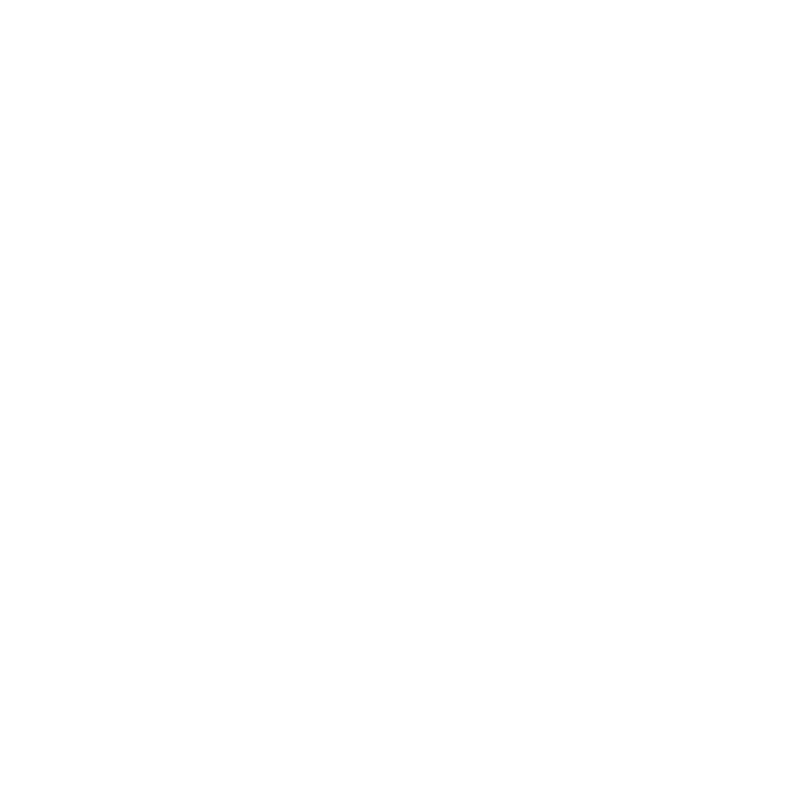

Peak at 234, start iteration with error = 0.5354343634818506
Peak at 234, iteration 0: error = 0.4133756245236216
Peak at 234, iteration 1: error = 0.10103171046190036
Peak at 234, iteration 2: error = 0.10103170864842008
    ----Saving data for block between 227.00 - 259.00


<IPython.core.display.Javascript object>


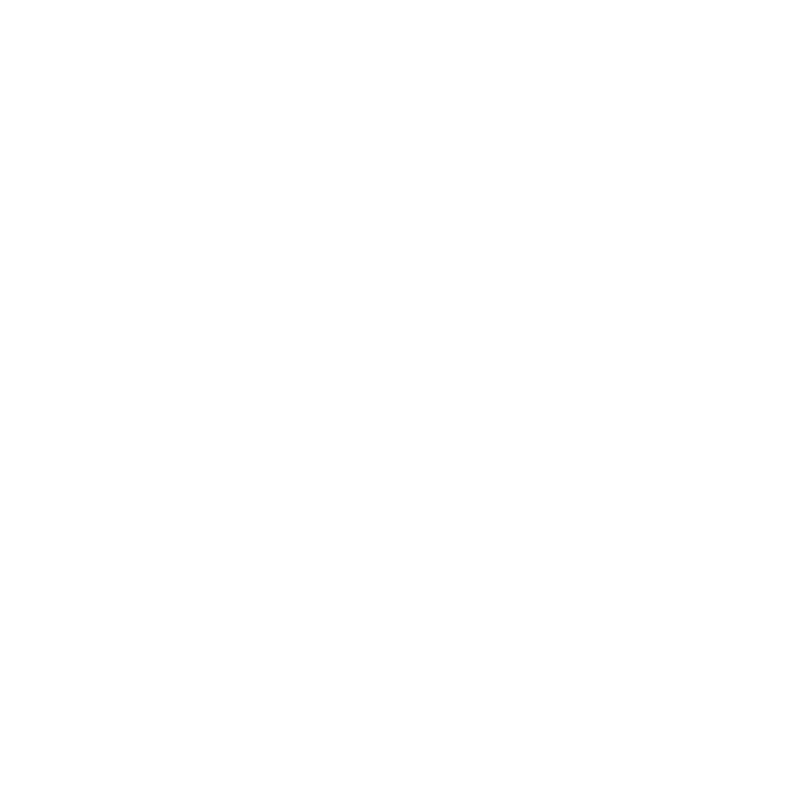

Peak at 279, start iteration with error = 0.644548125772103
Peak at 279, iteration 0: error = 0.2977971491770582
Peak at 279, iteration 1: error = 0.10576521052412957
Peak at 279, iteration 2: error = 0.06228057787140656
    ----Saving data for block between 260.00 - 300.00


<IPython.core.display.Javascript object>


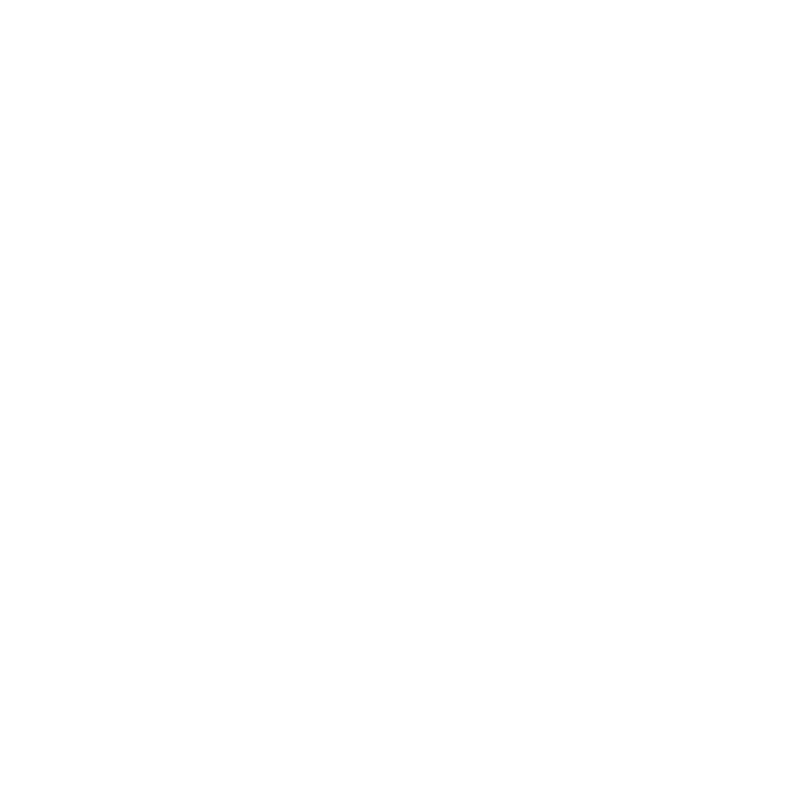

Peak at 309, start iteration with error = 0.9421483515452707
Peak at 309, iteration 0: error = 1.999173402265921
Peak at 309, iteration 1: error = 1.6135713456759475
Peak at 309, iteration 2: error = 1.1363097858462392
    ----Saving data for block between 301.00 - 346.00


<IPython.core.display.Javascript object>


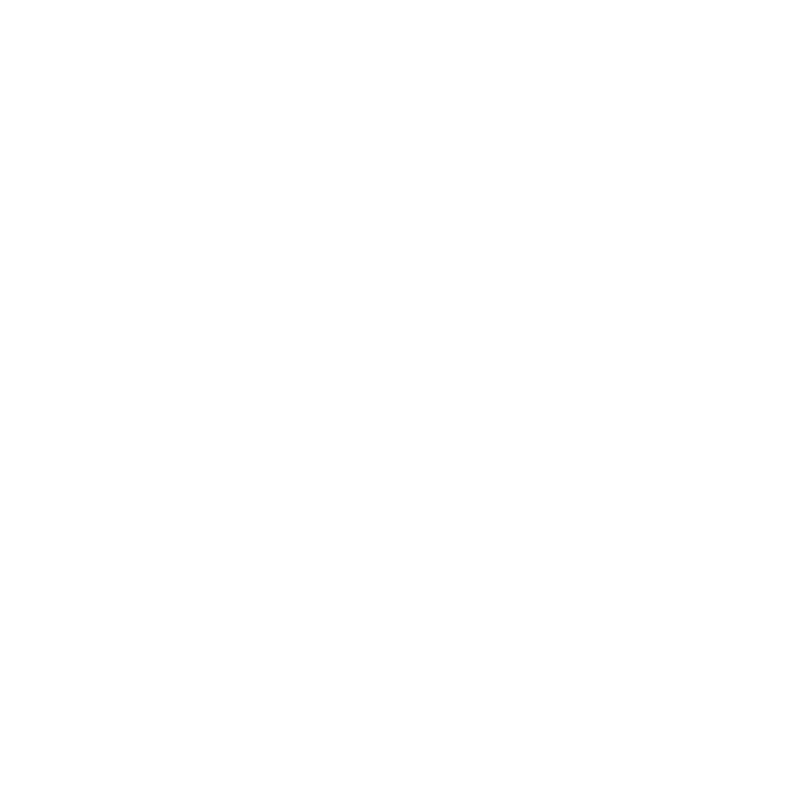

Peak at 381, start iteration with error = 0.8875163363173905
Peak at 381, iteration 0: error = 0.8706574064230472
Peak at 381, iteration 1: error = 0.21026421115617075
Peak at 381, iteration 2: error = 0.18004305807156737
    ----Saving data for block between 347.00 - 405.00


<IPython.core.display.Javascript object>


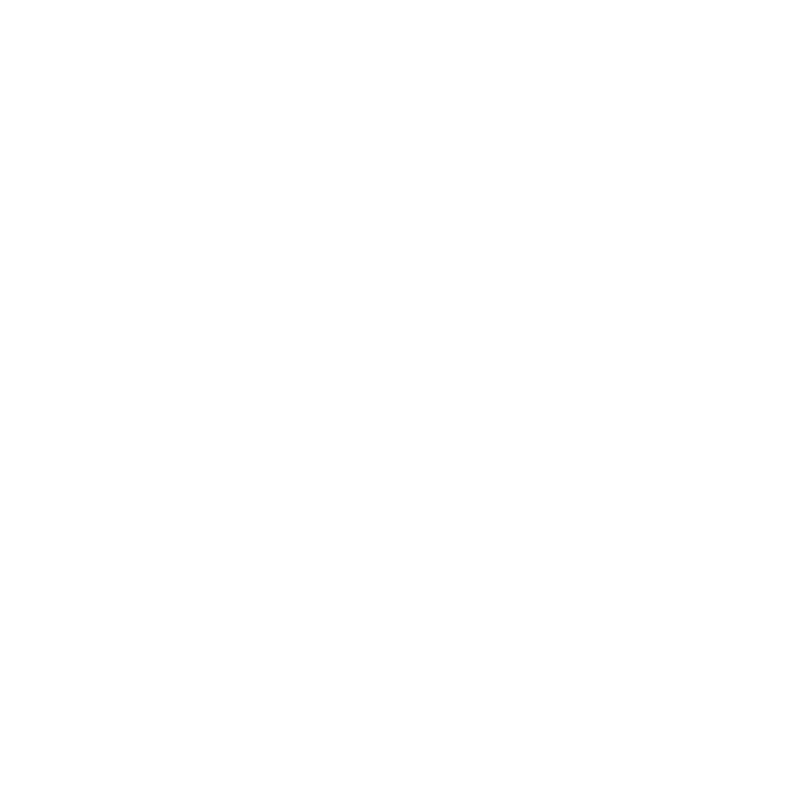

Peak at 421, start iteration with error = 0.4740316605763692
Peak at 421, iteration 0: error = 0.5245364783283922
Peak at 421, iteration 1: error = 0.023704375215962744
Peak at 421, iteration 2: error = 0.01383943915835723
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 406.00 - 424.00


<IPython.core.display.Javascript object>


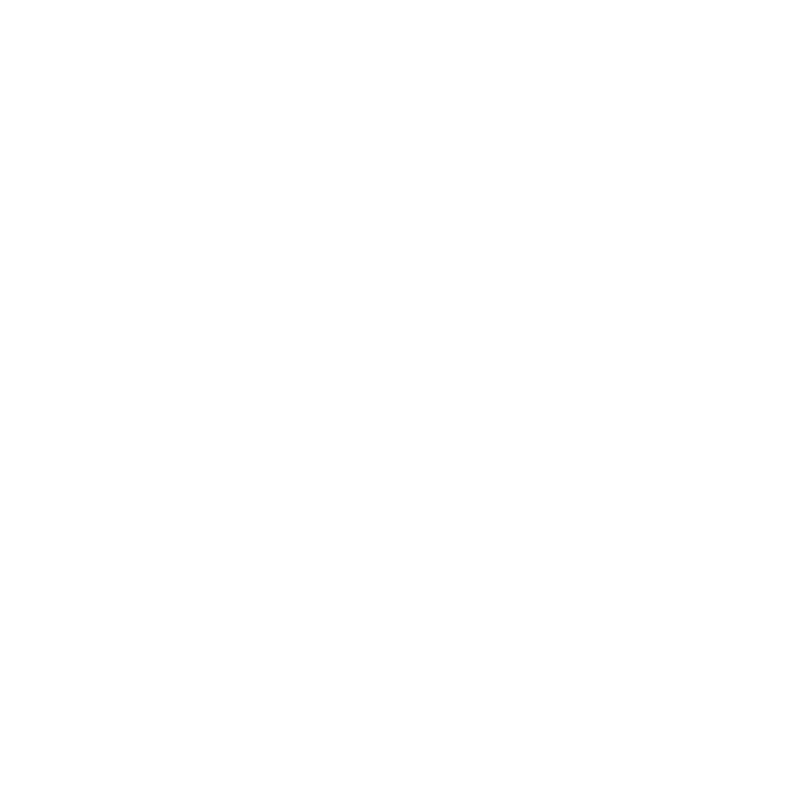

Peak at 436, start iteration with error = 0.5080693764453573
Peak at 436, iteration 0: error = 0.45763776976412657
Peak at 436, iteration 1: error = 0.06894475725637744
Peak at 436, iteration 2: error = 0.049058909732470804
    ----Saving data for block between 425.00 - 444.00


<IPython.core.display.Javascript object>


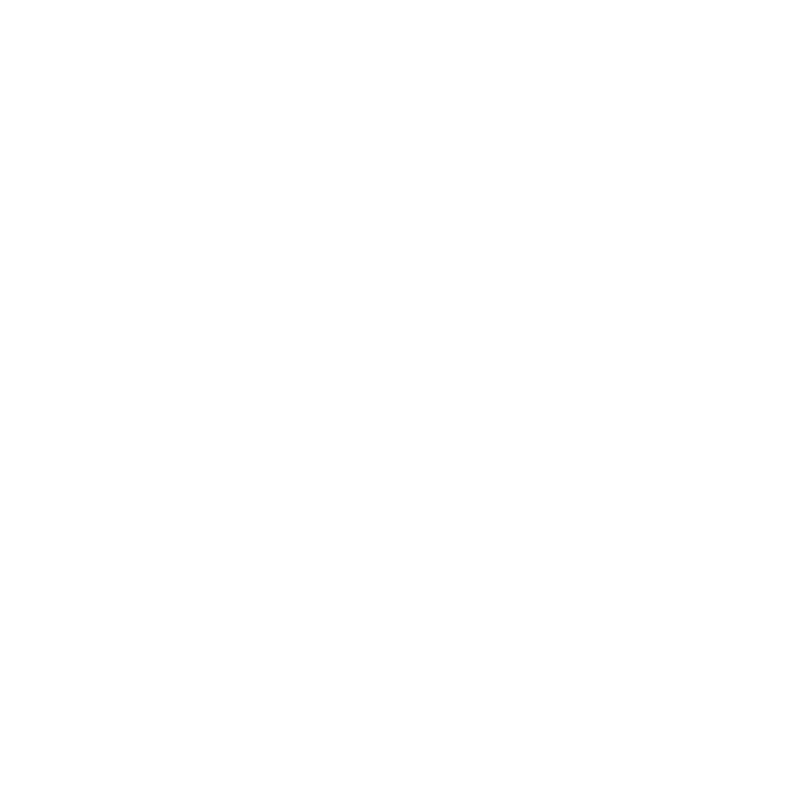

Peak at 458, start iteration with error = 0.45604220186603445
Peak at 458, iteration 0: error = 0.4163024623602289
Peak at 458, iteration 1: error = 0.046304186000933
Peak at 458, iteration 2: error = 0.059752944486200256
    ----Saving data for block between 445.00 - 490.00


<IPython.core.display.Javascript object>


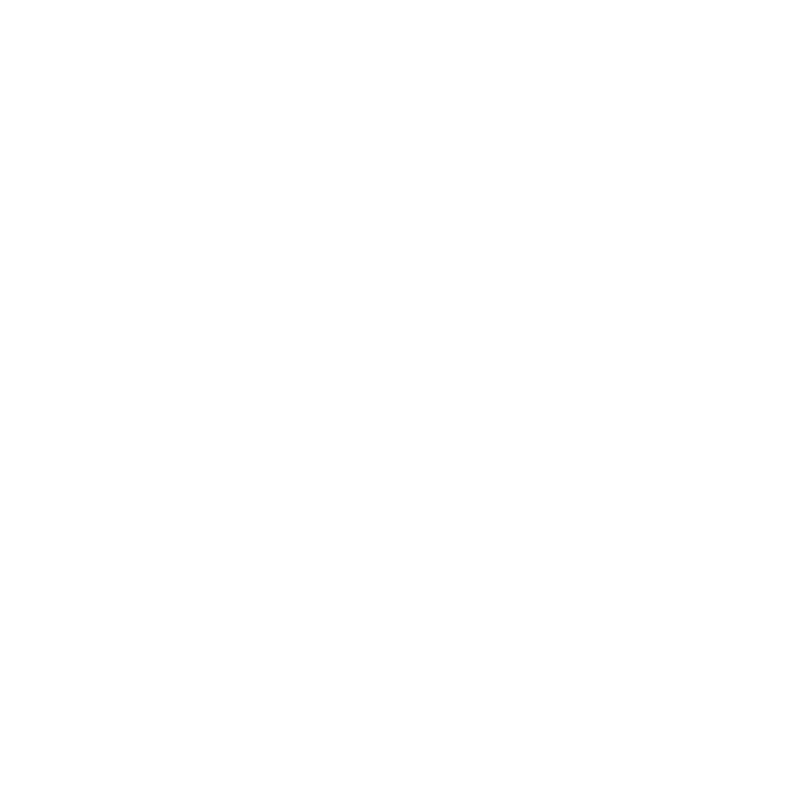

Peak at 519, start iteration with error = 0.5443486648916953
Peak at 519, iteration 0: error = 0.4233625210227655
Peak at 519, iteration 1: error = 0.11201980284870627
Peak at 519, iteration 2: error = 0.10820253649538769
    ----Saving data for block between 491.00 - 532.00


<IPython.core.display.Javascript object>


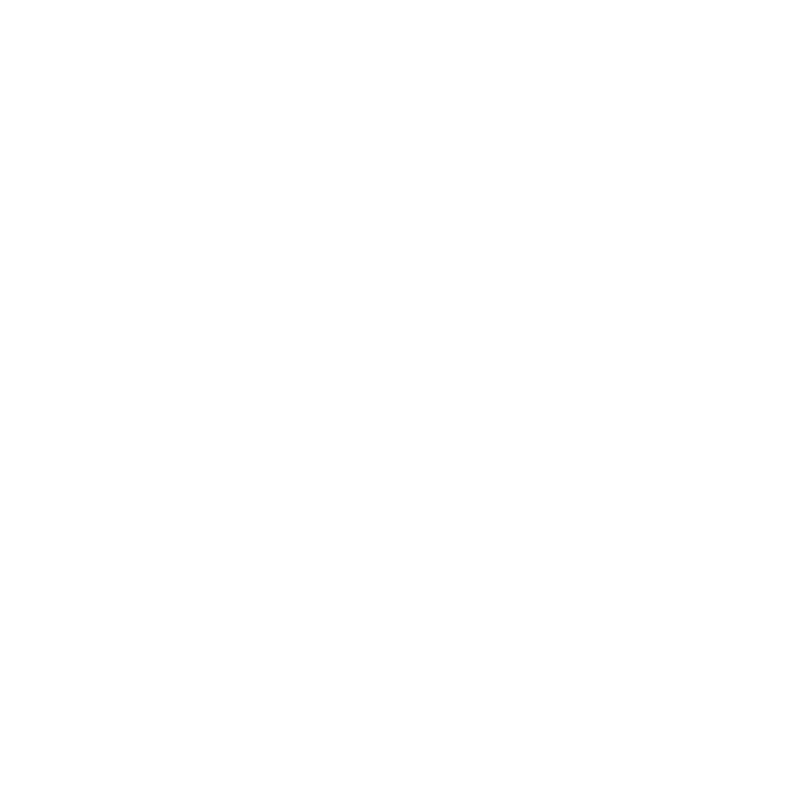

Peak at 550, start iteration with error = 0.903842368529769
Peak at 550, iteration 0: error = 4.7468792696466355
Peak at 550, iteration 1: error = 3.5897556127002126
Peak at 550, iteration 2: error = 2.0083937114934187
    ----Saving data for block between 533.00 - 596.00


<IPython.core.display.Javascript object>


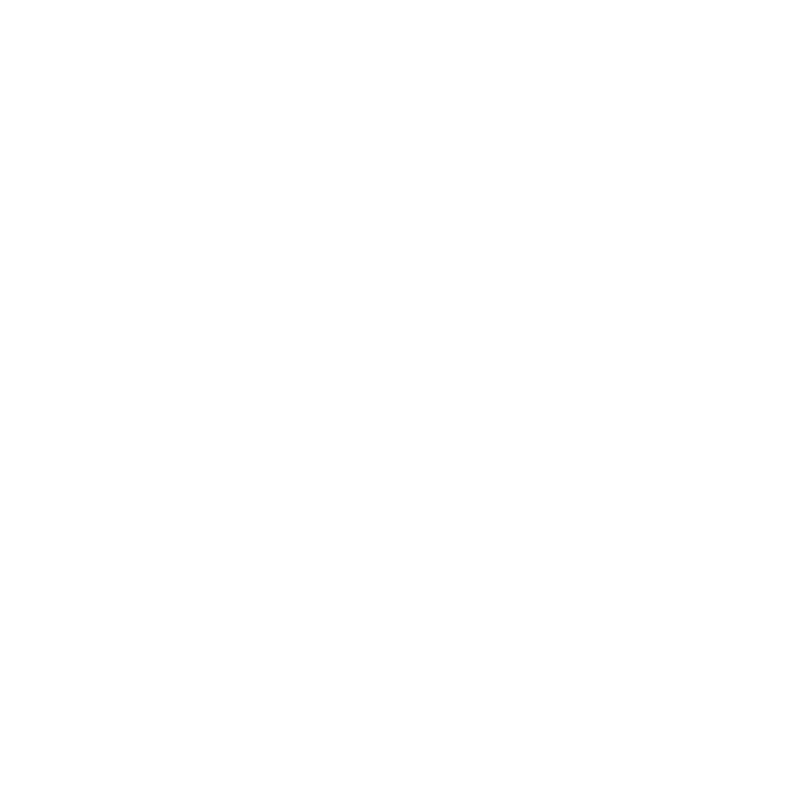

In [23]:
y4 = bgsub(patterns[i], npad = 1)

In [29]:
%matplotlib inline

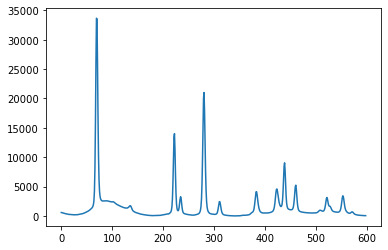

In [40]:
plt.plot(bgsubbed[i])

In [97]:
bgsubbed[i] = y3

ValueError: could not broadcast input array from shape (598,) into shape (0,)

> <ipython-input-97-9fc214c8e1ed>(1)<module>()
----> 1 bgsubbed[i] = y3

ipdb> c


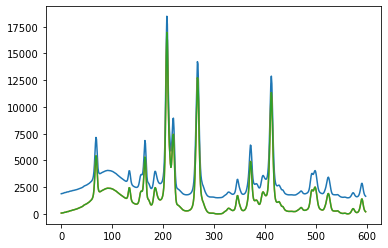

In [85]:
plt.plot(patterns[i])
plt.plot(bgsubbed[i])
plt.plot(y3)
#plt.plot(y4)

In [132]:
out10 = bgsub(patterns[10], npad = 30) 

numBlocks: 363, dataPts/Block: 1.6473829201101928
[30.0, 64.0, 160.0, 223.0, 257.0, 284.0, 326.0, 381.0, 435.0, 458.0, 477.0, 527.0, 538.0, 565.0, 591.0, 627.0]
Experimental Info used: 

{'blockBounds': [30.0, 64.0, 160.0, 223.0, 257.0, 284.0, 326.0, 381.0, 435.0, 458.0, 477.0, 527.0, 538.0, 565.0, 591.0, 627.0]}
Peak at 31, start iteration with error = 0.9375101293391642
Peak at 31, iteration 0: error = 1.6948511643132935
Peak at 31, iteration 1: error = 1.3245297788544659
Peak at 31, iteration 2: error = 1.2150760315804063
    ----Saving data for block between 30.00 - 63.00
Peak at 100, start iteration with error = 0.8758681370183146
Peak at 100, iteration 0: error = 1.0610332050025768
Peak at 100, iteration 1: error = 0.11658158982412396
Peak at 100, iteration 2: error = 0.06600567508292503
    ----Saving data for block between 64.00 - 159.00
Peak at 167, start iteration with error = 0.30745504891408104
Peak at 167, iteration 0: error = 0.6805569804299505
Peak at 167, iteration 1: e

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 538.00 - 564.00
Peak at 582, start iteration with error = 0.3484627937653459
Peak at 582, iteration 0: error = 0.6485076389044238
Peak at 582, iteration 1: error = 0.020242206427219116
Peak at 582, iteration 2: error = 0.01657800819736546
    ----Saving data for block between 565.00 - 590.00
Peak at 600, start iteration with error = 0.5959773795439833
Peak at 600, iteration 0: error = 0.4449952284228669
Peak at 600, iteration 1: error = 0.33344795099888214
Peak at 600, iteration 2: error = 0.4010153457303985
    ----Saving data for block between 591.00 - 626.00


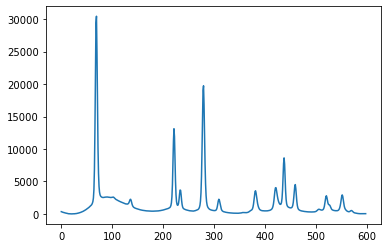

In [133]:
plt.plot(out10)

In [152]:
bgsubbed = np.vstack([bgsub(y, npad = 20) for y in patterns])

numBlocks: 358, dataPts/Block: 1.670391061452514
[ 20.  55. 147. 203. 250. 283. 317. 362. 428. 450. 468. 521. 532. 559.
 587. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  55., 147., 203., 250., 283., 317., 362., 428., 450., 468.,
       521., 532., 559., 587., 617.])}
Peak at 20, start iteration with error = 0.15583376043446323
Peak at 20, iteration 0: error = 0.8436229587351282
Peak at 20, iteration 1: error = 0.005610811318616927
Peak at 20, iteration 2: error = 0.004101421264093363
    ----Saving data for block between 20.00 - 54.00
Peak at 91, start iteration with error = 0.4201834540137265
Peak at 91, iteration 0: error = 0.5542185734670875
Peak at 91, iteration 1: error = 0.10047483626814498
Peak at 91, iteration 2: error = 0.05560989437968862
    ----Saving data for block between 55.00 - 146.00
Peak at 150, start iteration with error = 0.6382176902829311
Peak at 150, iteration 0: error = 0.3328846389586472
Peak at 150, iteration 1: error = 0.05966657566782098
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 543, start iteration with error = 0.25760655048866127
Peak at 543, iteration 0: error = 0.7364948483039648
Peak at 543, iteration 1: error = 0.03177524067463294
Peak at 543, iteration 2: error = 0.02326905976100127
    ----Saving data for block between 532.00 - 558.00
Peak at 575, start iteration with error = 0.31823938193903395
Peak at 575, iteration 0: error = 0.6773101743874758
Peak at 575, iteration 1: error = 0.0280176679242722
Peak at 575, iteration 2: error = 0.019430822525566445
    ----Saving data for block between 559.00 - 586.00
Peak at 592, start iteration with error = 0.40473438269322526
Peak at 592, iteration 0: error = 0.5906427777249271
Peak at 592, iteration 1: error = 0.0396449715424612
Peak at 592, iteration 2: error = 0.03964497154245806
    ----Saving data for block between 587.00 - 616.00
numBlocks: 358, dataPts/Block: 1.670391061452514
[ 20.  55. 147. 206. 250. 283. 317. 376. 428. 450. 468. 521. 531. 559.
 584. 617.]
Experimental Info used: 

{'blockBound

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 521.00 - 530.00
Peak at 543, start iteration with error = 0.46213081449003385
Peak at 543, iteration 0: error = 0.4983868257383461
Peak at 543, iteration 1: error = 0.0826918716372109
Peak at 543, iteration 2: error = 0.07029681722283292
    ----Saving data for block between 531.00 - 558.00
Peak at 574, start iteration with error = 0.3884371136446254
Peak at 574, iteration 0: error = 0.5959437557093241
Peak at 574, iteration 1: error = 0.07804706290609788
Peak at 574, iteration 2: error = 0.03883042632966887
    ----Saving data for block between 559.00 - 583.00
Peak at 592, start iteration with error = 0.8351001861278077
Peak at 592, iteration 0: error = 0.3411704714112672
Peak at 592, iteration 1: error = 0.6075188576980239
Peak at 592, iteration 2: error = 0.8670375224859992
    ----Saving data for block between 584.00 - 616.00
numBlocks: 364, dataPts/Block: 1.6428571428571428
[ 20.  55. 147. 203. 250. 283. 323. 360. 428. 451. 468. 508. 534. 559.

Peak at 459, start iteration with error = 0.5463183268589493
Peak at 459, iteration 0: error = 0.4346808473808374
Peak at 459, iteration 1: error = 0.04041397566267087
Peak at 459, iteration 2: error = 0.030802432052186114
    ----Saving data for block between 451.00 - 467.00
Peak at 481, start iteration with error = 0.5195093669802823
Peak at 481, iteration 0: error = 0.4099895308560142
Peak at 481, iteration 1: error = 0.03316973488288223
Peak at 481, iteration 2: error = 0.03364846859522981
    ----Saving data for block between 468.00 - 507.00
Peak at 530, start iteration with error = 0.2277386930665861
Peak at 530, iteration 0: error = 0.768638042494249
Peak at 530, iteration 1: error = 0.013684471657849253
Peak at 530, iteration 2: error = 0.009785374809502808
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 508.00 - 533.00
Peak at 543, start iteration with error = 0.45864911655775803
Peak at 543, iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 520.00 - 530.00
Peak at 542, start iteration with error = 0.36260959359603073
Peak at 542, iteration 0: error = 0.6127348447703083
Peak at 542, iteration 1: error = 0.04243950443961604
Peak at 542, iteration 2: error = 0.03483601199239333
    ----Saving data for block between 531.00 - 563.00
Peak at 574, start iteration with error = 0.46389881460272486
Peak at 574, iteration 0: error = 0.5327953398391558
Peak at 574, iteration 1: error = 0.02482780044314819
Peak at 574, iteration 2: error = 0.01593848947358767
    ----Saving data for block between 564.00 - 586.00
Peak at 592, start iteration with error = 0.5791288437429756
Peak at 592, iteration 0: error = 0.4037869387873988
Peak at 592, iteration 1: error = 0.062385254921129056
Peak at 592, iteration 2: error = 0.0610282726628951
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 587.00 - 616.00
numBlocks: 363, dataPts/Block:

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 520.00 - 529.00
Peak at 542, start iteration with error = 0.326833941374367
Peak at 542, iteration 0: error = 0.6569299076777781
Peak at 542, iteration 1: error = 0.044884275499733506
Peak at 542, iteration 2: error = 0.029270783387588293
    ----Saving data for block between 530.00 - 557.00
Peak at 574, start iteration with error = 0.30214896710227807
Peak at 574, iteration 0: error = 0.6961098439286194
Peak at 574, iteration 1: error = 0.01657720181891126
Peak at 574, iteration 2: error = 0.009512453628840865
    ----Saving data for block between 558.00 - 582.00
Peak at 592, start iteration with error = 0.5333578614702066
Peak at 592, iteration 0: error = 0.4347782500594173
Peak at 592, iteration 1: error = 0.10074302645713389
Peak at 592, iteration 2: error = 0.10364424047871042
    ----Saving data for block between 583.00 - 616.00
numBlocks: 359, dataPts/Block: 1.6657381615598885
[ 20.  55. 150. 201. 249. 282. 317. 359. 427. 449. 467. 519. 530.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 519.00 - 529.00
Peak at 542, start iteration with error = 0.11900645518481633
Peak at 542, iteration 0: error = 0.8801340745529682
Peak at 542, iteration 1: error = 0.012898186771002497
Peak at 542, iteration 2: error = 0.009851493712216303
    ----Saving data for block between 530.00 - 562.00
Peak at 573, start iteration with error = 0.17923283364675646
Peak at 573, iteration 0: error = 0.8179659371216318
Peak at 573, iteration 1: error = 0.014775135680511987
Peak at 573, iteration 2: error = 0.007361319311394931
    ----Saving data for block between 563.00 - 586.00
Peak at 587, start iteration with error = 0.3295552587021526
Peak at 587, iteration 0: error = 0.6663737464416869
Peak at 587, iteration 1: error = 0.01480491370949699
Peak at 587, iteration 2: error = 0.012733335383363664
    ----Saving data for block between 587.00 - 616.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[ 20.  55. 150. 202. 248. 282. 322. 371. 427. 449. 471. 506. 5

Peak at 480, start iteration with error = 0.3406031362453412
Peak at 480, iteration 0: error = 0.642437573617008
Peak at 480, iteration 1: error = 0.016406350414137284
Peak at 480, iteration 2: error = 0.01541113793952416
    ----Saving data for block between 467.00 - 505.00
Peak at 528, start iteration with error = 0.08657190486815225
Peak at 528, iteration 0: error = 0.9122818112641563
Peak at 528, iteration 1: error = 0.004061938606736454
Peak at 528, iteration 2: error = 0.003342443311748354
    ----Saving data for block between 506.00 - 528.00
Peak at 541, start iteration with error = 0.3271892805657544
Peak at 541, iteration 0: error = 0.6522556518467219
Peak at 541, iteration 1: error = 0.05240700077250609
Peak at 541, iteration 2: error = 0.033878645990359474
    ----Saving data for block between 529.00 - 555.00
Peak at 573, start iteration with error = 0.4067440057606478
Peak at 573, iteration 0: error = 0.5840792990283645
Peak at 573, iteration 1: error = 0.038934400694901804

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 541, iteration 1: error = 0.016842308693490845
Peak at 541, iteration 2: error = 0.010562967514761108
    ----Saving data for block between 529.00 - 561.00
Peak at 572, start iteration with error = 0.19175657058245835
Peak at 572, iteration 0: error = 0.8066944542485681
Peak at 572, iteration 1: error = 0.014097865466342554
Peak at 572, iteration 2: error = 0.010131762387034986
    ----Saving data for block between 562.00 - 581.00
Peak at 582, start iteration with error = 0.3656718425543609
Peak at 582, iteration 0: error = 0.6279171660313848
Peak at 582, iteration 1: error = 0.03893351573756064
Peak at 582, iteration 2: error = 0.013461234378388856
    ----Saving data for block between 582.00 - 616.00
numBlocks: 363, dataPts/Block: 1.6473829201101928
[ 20.  54. 150. 213. 247. 274. 316. 371. 425. 448. 467. 517. 528. 555.
 581. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  54., 150., 213., 247., 274., 316., 371., 425., 448., 467.,
       517., 528., 555., 581., 6

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 541, iteration 0: error = 0.7239975719149371
Peak at 541, iteration 1: error = 0.03971826637959274
Peak at 541, iteration 2: error = 0.03466669591035942
    ----Saving data for block between 528.00 - 554.00
Peak at 572, start iteration with error = 0.2642012097405715
Peak at 572, iteration 0: error = 0.7344703035887161
Peak at 572, iteration 1: error = 0.015113884558865151
Peak at 572, iteration 2: error = 0.010699609086080256
    ----Saving data for block between 555.00 - 580.00
Peak at 581, start iteration with error = 0.49483509820042815
Peak at 581, iteration 0: error = 0.48698621795940666
Peak at 581, iteration 1: error = 0.04771451540868446
Peak at 581, iteration 2: error = 0.019199658578200468
    ----Saving data for block between 581.00 - 616.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[ 20.  54. 150. 212. 248. 281. 316. 357. 425. 448. 466. 516. 531. 561.
 581. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  54., 150., 212., 248., 281., 316., 357.,

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 516.00 - 530.00
Peak at 541, start iteration with error = 0.29042105652897443
Peak at 541, iteration 0: error = 0.7010679181682934
Peak at 541, iteration 1: error = 0.04148831512924581
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 541, iteration 2: error = 0.7160841355660185
    ----Saving data for block between 531.00 - 560.00
Peak at 572, start iteration with error = 0.33802166290767366
Peak at 572, iteration 0: error = 0.6594808119407443
Peak at 572, iteration 1: error = 0.014386776906864157
Peak at 572, iteration 2: error = 0.008474925986705153
    ----Saving data for block between 561.00 - 580.00
Peak at 581, start iteration with error = 0.5026678831510636
Peak at 581, iteration 0: error = 0.4798546452506097
Peak at 581, iteration 1: error = 0.04410412887300706
Peak at 581, iteration 2: error = 0.018321949953661227
    ----Saving data for block between 581.00 - 616.00
numBlocks: 366, dataPts/Bloc

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 516.00 - 525.00
Peak at 540, start iteration with error = 0.3049175958475366
Peak at 540, iteration 0: error = 0.6808793725986857
Peak at 540, iteration 1: error = 0.041176756293471575
Peak at 540, iteration 2: error = 0.03270275663288664
    ----Saving data for block between 526.00 - 560.00
Peak at 571, start iteration with error = 0.37634102191865326
Peak at 571, iteration 0: error = 0.6221208928045288
Peak at 571, iteration 1: error = 0.02035542675084612
Peak at 571, iteration 2: error = 0.010988385098043207
    ----Saving data for block between 561.00 - 580.00
Peak at 589, start iteration with error = 0.5283743468946397
Peak at 589, iteration 0: error = 0.4494980769070811
Peak at 589, iteration 1: error = 0.09340640199005157
Peak at 589, iteration 2: error = 0.09722446166360418
    ----Saving data for block between 581.00 - 616.00
numBlocks: 371, dataPts/Block: 1.6118598382749325
[ 20.  53. 150. 209. 247. 281. 321. 370. 425. 447. 466. 515. 526.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 515.00 - 525.00
Peak at 540, start iteration with error = 0.11305488862222456
Peak at 540, iteration 0: error = 0.886298603950428
Peak at 540, iteration 1: error = 0.01363357586705241
Peak at 540, iteration 2: error = 0.008894430553131124
    ----Saving data for block between 526.00 - 553.00
Peak at 571, start iteration with error = 0.16918232366352118
Peak at 571, iteration 0: error = 0.8284101738110854
Peak at 571, iteration 1: error = 0.02140229526116597
Peak at 571, iteration 2: error = 0.015491757029611877
    ----Saving data for block between 554.00 - 580.00
Peak at 581, start iteration with error = 0.365236093915011
Peak at 581, iteration 0: error = 0.6288854873060875
Peak at 581, iteration 1: error = 0.016657769988336298
Peak at 581, iteration 2: error = 0.013982087495121242
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 581.00 - 616.00
numBlocks: 367, dataPts/Bloc

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 515.00 - 525.00
Peak at 540, start iteration with error = 0.35111087671498775
Peak at 540, iteration 0: error = 0.6300566879434725
Peak at 540, iteration 1: error = 0.0647642902376531
Peak at 540, iteration 2: error = 0.06473404539501151
    ----Saving data for block between 526.00 - 559.00
Peak at 571, start iteration with error = 0.4880150599899254
Peak at 571, iteration 0: error = 0.5050352341206249
Peak at 571, iteration 1: error = 0.024562466972082583
Peak at 571, iteration 2: error = 0.023054367315751098
    ----Saving data for block between 560.00 - 584.00
Peak at 588, start iteration with error = 0.7008133153090356
Peak at 588, iteration 0: error = 0.21905979805872727
Peak at 588, iteration 1: error = 0.10050392973800315
Peak at 588, iteration 2: error = 0.10049806843681733
    ----Saving data for block between 585.00 - 616.00
numBlocks: 373, dataPts/Block: 1.6032171581769437
[ 20.  53. 150. 207. 246. 280. 321. 368. 425. 448. 466. 514. 560.

Peak at 570, start iteration with error = 0.4827990429447089
Peak at 570, iteration 0: error = 0.5110673386972044
Peak at 570, iteration 1: error = 0.0496492132946151
Peak at 570, iteration 2: error = 0.049649213106743875
    ----Saving data for block between 554.00 - 616.00
numBlocks: 378, dataPts/Block: 1.582010582010582
[ 20.  52. 147. 206. 247. 280. 321. 369. 425. 446. 469. 514. 553. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  52., 147., 206., 247., 280., 321., 369., 425., 446., 469.,
       514., 553., 617.])}
Peak at 21, start iteration with error = 0.559921993050772
Peak at 21, iteration 0: error = 0.3765238393484964
Peak at 21, iteration 1: error = 0.1152140552197788
Peak at 21, iteration 2: error = 0.09923373641994765
    ----Saving data for block between 20.00 - 51.00
Peak at 89, start iteration with error = 0.8636954135588606
Peak at 89, iteration 0: error = 0.8796181775212665
Peak at 89, iteration 1: error = 0.05286029857237345
Peak at 89, iteration 2: err

Peak at 21, start iteration with error = 0.7168480278546115
Peak at 21, iteration 0: error = 0.24229086433871358
Peak at 21, iteration 1: error = 0.09809781211199954
Peak at 21, iteration 2: error = 0.04643092807956287
    ----Saving data for block between 20.00 - 42.00
Peak at 89, start iteration with error = 0.8990612763504785
Peak at 89, iteration 0: error = 3.3711059352789094
Peak at 89, iteration 1: error = 0.405878502335267
Peak at 89, iteration 2: error = 0.3729118600124644
    ----Saving data for block between 43.00 - 149.00
Peak at 156, start iteration with error = 0.9340104563485716
Peak at 156, iteration 0: error = 2.217169820916442
Peak at 156, iteration 1: error = 1.6220186358734896
Peak at 156, iteration 2: error = 1.6220187359833955
    ----Saving data for block between 150.00 - 204.00
Peak at 241, start iteration with error = 0.8025686729838408
Peak at 241, iteration 0: error = 0.4970597962250283
Peak at 241, iteration 1: error = 0.07858384561052609
Peak at 241, iterati

Peak at 146, start iteration with error = 0.7262875576220785
Peak at 146, iteration 0: error = 0.24038652959166995
Peak at 146, iteration 1: error = 0.0896410390017486
Peak at 146, iteration 2: error = 0.03499941280096024
    ----Saving data for block between 146.00 - 204.00
Peak at 240, start iteration with error = 0.7768193772810734
Peak at 240, iteration 0: error = 1.4946680416101301
Peak at 240, iteration 1: error = 0.8899706986780345
Peak at 240, iteration 2: error = 0.6355454207720177
    ----Saving data for block between 205.00 - 246.00
Peak at 279, start iteration with error = 0.5883515809567158
Peak at 279, iteration 0: error = 0.30950397666072327
Peak at 279, iteration 1: error = 0.24117197768438675
Peak at 279, iteration 2: error = 0.16149402431960447
    ----Saving data for block between 247.00 - 279.00
Peak at 298, start iteration with error = 0.5928111780979661
Peak at 298, iteration 0: error = 0.3630771957180318
Peak at 298, iteration 1: error = 0.11396094065262294
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 386, dataPts/Block: 1.549222797927461
[ 20.  51. 146. 207. 245. 279. 321. 365. 427. 446. 467. 508. 553. 611.
 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  51., 146., 207., 245., 279., 321., 365., 427., 446., 467.,
       508., 553., 611., 617.])}
Peak at 21, start iteration with error = 0.9311325110925203
Peak at 21, iteration 0: error = 2.0577771129720994
Peak at 21, iteration 1: error = 1.472774149650298
Peak at 21, iteration 2: error = 1.2715507401972468
    ----Saving data for block between 20.00 - 50.00
Peak at 90, start iteration with error = 0.8728753355205374
Peak at 90, iteration 0: error = 1.0976398898608104
Peak at 90, iteration 1: error = 0.4729896417834449
Peak at 90, iteration 2: error = 0.22021325095390373
    ----Saving data for block between 51.00 - 145.00
Peak at 156, start iteration with error = 0.2286159979798667
Peak at 156, iteration 0: error = 0.7568471663429724
Peak at 156, iteration 1: error = 0.04156147089376713
Peak at 156, iterati

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 611.00 - 616.00
numBlocks: 389, dataPts/Block: 1.5372750642673523
[ 20.  50. 149. 183. 207. 246. 279. 315. 363. 427. 446. 467. 508. 552.
 611. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  50., 149., 183., 207., 246., 279., 315., 363., 427., 446.,
       467., 508., 552., 611., 617.])}
Peak at 21, start iteration with error = 0.1863716295652764
Peak at 21, iteration 0: error = 0.8092153992832649
Peak at 21, iteration 1: error = 0.02224504519941704
Peak at 21, iteration 2: error = 0.022526533655466325
    ----Saving data for block between 20.00 - 49.00
Peak at 90, start iteration with error = 0.7581021141212231
Peak at 90, iteration 0: error = 0.5929484861427272
Peak at 90, iteration 1: error = 0.3397337096964209
Peak at 90, iteration 2: error = 0.33973371020096216
    ----Saving data for block between 50.00 - 148.00
Peak at 156, start iteration with error = 0.3384242420443453
Peak at 156, iteration 0: error = 0.6493088236206804
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 611.00 - 616.00
numBlocks: 389, dataPts/Block: 1.5372750642673523
[ 20.  36. 149. 183. 207. 246. 279. 321. 362. 427. 461. 507. 552. 610.
 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  36., 149., 183., 207., 246., 279., 321., 362., 427., 461.,
       507., 552., 610., 617.])}
Peak at 20, start iteration with error = 0.6104143962079354
Peak at 20, iteration 0: error = 0.35307962930743564
Peak at 20, iteration 1: error = 0.07989704393667903
Peak at 20, iteration 2: error = 0.07597409125222948
    ----Saving data for block between 20.00 - 35.00
Peak at 91, start iteration with error = 0.9185838443489769
Peak at 91, iteration 0: error = 6.437883000489233
Peak at 91, iteration 1: error = 6.112710947969561
Peak at 91, iteration 2: error = 6.112455732447876
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 36.00 - 148.00
Peak at 156, start iteration with error = 0.578

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 392, dataPts/Block: 1.5255102040816326
[ 20.  49. 149. 181. 207. 245. 279. 320. 362. 427. 465. 507. 552. 609.
 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  49., 149., 181., 207., 245., 279., 320., 362., 427., 465.,
       507., 552., 609., 617.])}
Peak at 21, start iteration with error = 0.06938813975502339
Peak at 21, iteration 0: error = 0.9294807023109435
Peak at 21, iteration 1: error = 0.00555442551205906
Peak at 21, iteration 2: error = 0.00473730139459522
    ----Saving data for block between 20.00 - 48.00
Peak at 91, start iteration with error = 0.5540853361187338
Peak at 91, iteration 0: error = 0.3190807477488831
Peak at 91, iteration 1: error = 0.33575779503384007
Peak at 91, iteration 2: error = 0.33575779496306224
    ----Saving data for block between 49.00 - 148.00
Peak at 156, start iteration with error = 0.2885643794843782
Peak at 156, iteration 0: error = 0.7030979948769356
Peak at 156, iteration 1: error = 0.02692963013599653
Peak at 156, i

    ----Saving data for block between 552.00 - 571.00
Peak at 579, start iteration with error = 0.7226556919578823
Peak at 579, iteration 0: error = 0.26429686769308014
Peak at 579, iteration 1: error = 0.06776930362559885
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 579, iteration 2: error = 0.23011226844061614
    ----Saving data for block between 572.00 - 608.00
Peak at 616, start iteration with error = 0.3194633569786598
Peak at 616, iteration 0: error = 0.6626806268963532
Peak at 616, iteration 1: error = 0.015630204455526583
Peak at 616, iteration 2: error = 0.012668233239195274


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 609.00 - 616.00
numBlocks: 388, dataPts/Block: 1.541237113402062
[ 20.  47. 149. 180. 208. 244. 279. 319. 362. 427. 463. 506. 552. 575.
 608. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  47., 149., 180., 208., 244., 279., 319., 362., 427., 463.,
       506., 552., 575., 608., 617.])}
Peak at 21, start iteration with error = 0.3229458861499388
Peak at 21, iteration 0: error = 0.6411754791429877
Peak at 21, iteration 1: error = 0.07568293116846041
Peak at 21, iteration 2: error = 0.056845154933077575
    ----Saving data for block between 20.00 - 46.00
Peak at 92, start iteration with error = 0.8444711044461916
Peak at 92, iteration 0: error = 1.0196651113601882
Peak at 92, iteration 1: error = 0.06932702832666696
Peak at 92, iteration 2: error = 0.07329059344448778
    ----Saving data for block between 47.00 - 148.00
Peak at 156, start iteration with error = 0.34896057030843497
Peak at 156, iteration 0: error = 0.6362264261698428
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 608.00 - 616.00
numBlocks: 399, dataPts/Block: 1.4987468671679198
[ 20.  42. 145. 179. 208. 245. 278. 319. 361. 376. 427. 459. 506. 551.
 574. 608. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  42., 145., 179., 208., 245., 278., 319., 361., 376., 427.,
       459., 506., 551., 574., 608., 617.])}
Peak at 41, start iteration with error = 0.13417036131303298
Peak at 41, iteration 0: error = 0.8615637270718584
Peak at 41, iteration 1: error = 0.01899456706953259
Peak at 41, iteration 2: error = 0.015408175868409686
    ----Saving data for block between 20.00 - 41.00
Peak at 92, start iteration with error = 0.7248545541769018
Peak at 92, iteration 0: error = 0.5290166074074446
Peak at 92, iteration 1: error = 0.06331787653231993
Peak at 92, iteration 2: error = 0.05608009102298368
    ----Saving data for block between 42.00 - 144.00
Peak at 156, start iteration with error = 0.288152298751969
Peak at 156, iteration 0: error = 0.687643461

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 361.00 - 375.00
Peak at 405, start iteration with error = 0.5710846804739517
Peak at 405, iteration 0: error = 0.41640461483846974
Peak at 405, iteration 1: error = 0.05822116197236306
Peak at 405, iteration 2: error = 0.04111171465282048
    ----Saving data for block between 376.00 - 426.00
Peak at 448, start iteration with error = 0.7060789940694432
Peak at 448, iteration 0: error = 0.27991919741295535
Peak at 448, iteration 1: error = 0.0965563329123432
Peak at 448, iteration 2: error = 0.034028621144874746
    ----Saving data for block between 427.00 - 458.00
Peak at 474, start iteration with error = 0.5626639770256623
Peak at 474, iteration 0: error = 0.37580446579400206
Peak at 474, iteration 1: error = 0.32843621247079013
Peak at 474, iteration 2: error = 0.34953777156716137
    ----Saving data for block between 459.00 - 505.00
Peak at 536, start iteration with error = 0.6773400500815542
Peak at 536, iteration 0: error = 0.30890621404258567


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 608.00 - 616.00
numBlocks: 398, dataPts/Block: 1.5025125628140703
[ 20.  24. 145. 179. 208. 244. 278. 319. 361. 375. 427. 461. 506. 551.
 573. 608. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  24., 145., 179., 208., 244., 278., 319., 361., 375., 427.,
       461., 506., 551., 573., 608., 617.])}
Peak at 21, start iteration with error = 0.6726130405215565
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 21, iteration 0: error = 0.4981136313140352
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 21, iteration 1: error = 0.41074640726260353
Peak at 21, iteration 2: error = 0.4545249704381441
    ----Saving data for block between 20.00 - 23.00
Peak at 93, start iteration with error = 0.9833190234578401
Peak at 93, iteration 0: error = 12.72394232802502


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 93, iteration 1: error = 0.981487746015416
Peak at 93, iteration 2: error = 0.9814877473279151
    ----Saving data for block between 24.00 - 144.00
Peak at 156, start iteration with error = 0.3636144668962594
Peak at 156, iteration 0: error = 0.5894081349332534
Peak at 156, iteration 1: error = 0.0335689073251618
Peak at 156, iteration 2: error = 0.035046553740005496
    ----Saving data for block between 145.00 - 178.00
Peak at 190, start iteration with error = 0.2131756768752304
Peak at 190, iteration 0: error = 0.7851791373761647
Peak at 190, iteration 1: error = 0.006270374507485736
Peak at 190, iteration 2: error = 0.006270374515262635
    ----Saving data for block between 179.00 - 207.00
Peak at 238, start iteration with error = 0.6158269264106699
Peak at 238, iteration 0: error = 0.3396794500917611
Peak at 238, iteration 1: error = 0.13216181679770841
Peak at 238, iteration 2: error = 0.13216181743084868
    ----Saving data for block between 208.00 - 243.00
Peak at 250, s

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 405, start iteration with error = 0.5620680393713973
Peak at 405, iteration 0: error = 0.4214047040932574
Peak at 405, iteration 1: error = 0.06118100558411128
Peak at 405, iteration 2: error = 0.042328038251052434
    ----Saving data for block between 375.00 - 426.00
Peak at 448, start iteration with error = 0.6762708344783246
Peak at 448, iteration 0: error = 0.30638416707503063
Peak at 448, iteration 1: error = 0.08814945508314959
Peak at 448, iteration 2: error = 0.036332080013306775
    ----Saving data for block between 427.00 - 460.00
Peak at 473, start iteration with error = 0.4354209752236444
Peak at 473, iteration 0: error = 0.5063317374441016
Peak at 473, iteration 1: error = 0.15803446228927853
Peak at 473, iteration 2: error = 0.1580344648590501
    ----Saving data for block between 461.00 - 505.00
Peak at 536, start iteration with error = 0.5338700318982316
Peak at 536, iteration 0: error = 0.4162257654053891
Peak at 536, iteration 1: error = 0.10777033573555032
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 608.00 - 616.00
numBlocks: 402, dataPts/Block: 1.4875621890547264
[ 20. 145. 179. 208. 245. 277. 318. 360. 376. 426. 461. 505. 551. 570.
 606. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 145., 179., 208., 245., 277., 318., 360., 376., 426., 461.,
       505., 551., 570., 606., 617.])}
Peak at 93, start iteration with error = 0.6601886796800047
Peak at 93, iteration 0: error = 0.8773838024171366
Peak at 93, iteration 1: error = 0.0634770460405621
Peak at 93, iteration 2: error = 0.06347704606501806
    ----Saving data for block between 20.00 - 144.00
Peak at 156, start iteration with error = 0.406891427857463
Peak at 156, iteration 0: error = 0.5233184299716195
Peak at 156, iteration 1: error = 0.040046328692074834
Peak at 156, iteration 2: error = 0.04004632868133354
    ----Saving data for block between 145.00 - 178.00
Peak at 190, start iteration with error = 0.27187170602115274
Peak at 190, iteration 0: error = 0.726046046382915

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 606.00 - 616.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[ 20. 148. 178. 209. 243. 275. 318. 360. 384. 426. 459. 502. 544. 572.
 605. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 148., 178., 209., 243., 275., 318., 360., 384., 426., 459.,
       502., 544., 572., 605., 617.])}
Peak at 93, start iteration with error = 0.9136998368789596
Peak at 93, iteration 0: error = 2.6971895601694396
Peak at 93, iteration 1: error = 0.29378109084445087
Peak at 93, iteration 2: error = 0.29378109260936264
    ----Saving data for block between 20.00 - 147.00
Peak at 155, start iteration with error = 0.33253867492479744
Peak at 155, iteration 0: error = 0.6558730255834668
Peak at 155, iteration 1: error = 0.03136169361326547
Peak at 155, iteration 2: error = 0.03353682002736728
    ----Saving data for block between 148.00 - 177.00
Peak at 190, start iteration with error = 0.2524736216088521
Peak at 190, iteration 0: error = 0.74577102353808

    ----Saving data for block between 544.00 - 570.00
Peak at 580, start iteration with error = 0.9055852101988067
Peak at 580, iteration 0: error = 0.6335165663963972
Peak at 580, iteration 1: error = 0.5657472386225887
Peak at 580, iteration 2: error = 0.20458663532493548
    ----Saving data for block between 571.00 - 602.00
Peak at 616, start iteration with error = 0.6947920908684057
Peak at 616, iteration 0: error = 0.24262957512430502
Peak at 616, iteration 1: error = 0.12713114387103372
Peak at 616, iteration 2: error = 0.056655817493081295
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 603.00 - 616.00
numBlocks: 419, dataPts/Block: 1.4272076372315037
[ 20. 148. 177. 209. 242. 274. 317. 359. 379. 424. 455. 494. 548. 567.
 601. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 148., 177., 209., 242., 274., 317., 359., 379., 424., 455.,
       494., 548., 567., 601., 617.])}
Peak at 93, start it

Peak at 444, start iteration with error = 0.6988164929890558
Peak at 444, iteration 0: error = 0.32707430126292736
Peak at 444, iteration 1: error = 0.2358550631684283
Peak at 444, iteration 2: error = 0.06120712407432304
    ----Saving data for block between 423.00 - 455.00
Peak at 467, start iteration with error = 0.7049648426145422
Peak at 467, iteration 0: error = 0.3043973212709455
Peak at 467, iteration 1: error = 0.19028589411392482
Peak at 467, iteration 2: error = 0.21559522912331316
    ----Saving data for block between 456.00 - 490.00
Peak at 530, start iteration with error = 0.7580514132339681
Peak at 530, iteration 0: error = 0.3634825013066335
Peak at 530, iteration 1: error = 0.3845024511504522
Peak at 530, iteration 2: error = 0.14243216842473178
    ----Saving data for block between 491.00 - 545.00
Peak at 558, start iteration with error = 0.5983431238223942
Peak at 558, iteration 0: error = 0.39544112024801953
Peak at 558, iteration 1: error = 0.021952043895697007
Pea

    ----Saving data for block between 240.00 - 272.00
Peak at 294, start iteration with error = 0.5935967845696557
Peak at 294, iteration 0: error = 0.396698078283717
Peak at 294, iteration 1: error = 0.07920238874957618
Peak at 294, iteration 2: error = 0.07920238875402633
    ----Saving data for block between 273.00 - 315.00
Peak at 326, start iteration with error = 0.448169477278239
Peak at 326, iteration 0: error = 0.540713892359208
Peak at 326, iteration 1: error = 0.032675711192621734
Peak at 326, iteration 2: error = 0.03326511315826301
    ----Saving data for block between 316.00 - 355.00
Peak at 373, start iteration with error = 0.6147635815238118
Peak at 373, iteration 0: error = 0.3758362485143439
Peak at 373, iteration 1: error = 0.03629227749769384
Peak at 373, iteration 2: error = 0.023179444473591194
    ----Saving data for block between 356.00 - 382.00
Peak at 400, start iteration with error = 0.5458755945263608
Peak at 400, iteration 0: error = 0.4490202618394654
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 527, start iteration with error = 0.604634233240066
Peak at 527, iteration 0: error = 0.5042412729907386
Peak at 527, iteration 1: error = 0.3671999400996933
Peak at 527, iteration 2: error = 0.14989748973645628
    ----Saving data for block between 503.00 - 539.00
Peak at 555, start iteration with error = 0.5465944504169197
Peak at 555, iteration 0: error = 0.4421594054783634
Peak at 555, iteration 1: error = 0.05811074056395518
Peak at 555, iteration 2: error = 0.03465350550802973
    ----Saving data for block between 540.00 - 561.00
Peak at 574, start iteration with error = 0.8524734264156123
Peak at 574, iteration 0: error = 1.1917432279880524
Peak at 574, iteration 1: error = 0.5753148978739567
Peak at 574, iteration 2: error = 0.36158712993562536
    ----Saving data for block between 562.00 - 591.00
Peak at 603, start iteration with error = 0.6767674968059395
Peak at 603, iteration 0: error = 0.26501024123056566
Peak at 603, iteration 1: error = 0.04588330197559551
Peak a

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 592.00 - 603.00
Peak at 616, start iteration with error = 0.28037579567605153
Peak at 616, iteration 0: error = 0.7104585115685494
Peak at 616, iteration 1: error = 0.0438718099436834
Peak at 616, iteration 2: error = 0.029960041191368934


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 604.00 - 616.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[ 20. 148. 176. 207. 239. 274. 309. 348. 383. 420. 454. 488. 507. 539.
 564. 592. 604. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 148., 176., 207., 239., 274., 309., 348., 383., 420., 454.,
       488., 507., 539., 564., 592., 604., 617.])}
Peak at 92, start iteration with error = 0.356102004457015
Peak at 92, iteration 0: error = 0.539109655932037
Peak at 92, iteration 1: error = 0.023822497731365404
Peak at 92, iteration 2: error = 0.02382249770471718
    ----Saving data for block between 20.00 - 147.00
Peak at 155, start iteration with error = 0.3480563279276863
Peak at 155, iteration 0: error = 0.6414285981158684
Peak at 155, iteration 1: error = 0.02752400762696091
Peak at 155, iteration 2: error = 0.02876403740733941
    ----Saving data for block between 148.00 - 175.00
Peak at 188, start iteration with error = 0.4661810430341358
Peak at 188, iteration 0: erro

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 592.00 - 603.00
Peak at 616, start iteration with error = 0.6366192217459913
Peak at 616, iteration 0: error = 0.32690530463792117
Peak at 616, iteration 1: error = 0.2708692342115463
Peak at 616, iteration 2: error = 0.24401595289865738


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 604.00 - 616.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[ 20. 148. 176. 207. 239. 274. 308. 346. 378. 420. 453. 488. 503. 543.
 564. 592. 608. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 148., 176., 207., 239., 274., 308., 346., 378., 420., 453.,
       488., 503., 543., 564., 592., 608., 617.])}
Peak at 20, start iteration with error = 0.5457879735296014
Peak at 20, iteration 0: error = 0.43571995847902
Peak at 20, iteration 1: error = 0.0450271208652579
Peak at 20, iteration 2: error = 0.04025180082761905
    ----Saving data for block between 20.00 - 147.00
Peak at 148, start iteration with error = 0.2502125528313503
Peak at 148, iteration 0: error = 0.7480274749872663
Peak at 148, iteration 1: error = 0.022777173111684274
Peak at 148, iteration 2: error = 0.008323118189125683
    ----Saving data for block between 148.00 - 175.00
Peak at 188, start iteration with error = 0.37155565924643785
Peak at 188, iteration 0: err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 488.00 - 502.00
Peak at 521, start iteration with error = 0.0737366550400318
Peak at 521, iteration 0: error = 0.925973501971254
Peak at 521, iteration 1: error = 0.00898385707618105
Peak at 521, iteration 2: error = 0.00440102005174458
    ----Saving data for block between 503.00 - 542.00
Peak at 553, start iteration with error = 0.08435784049106938
Peak at 553, iteration 0: error = 0.9146441138859015
Peak at 553, iteration 1: error = 0.00841206009671058
Peak at 553, iteration 2: error = 0.003504711685919666
    ----Saving data for block between 543.00 - 563.00
Peak at 564, start iteration with error = 0.17509907133493868
Peak at 564, iteration 0: error = 0.8233848968810936
Peak at 564, iteration 1: error = 0.009814689161607363
Peak at 564, iteration 2: error = 0.0044579544446977214
    ----Saving data for block between 564.00 - 591.00
Peak at 592, start iteration with error = 0.17128104817700257
Peak at 592, iteration 0: error = 0.827531453514280

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 608.00 - 616.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[ 20. 145. 176. 208. 239. 274. 315. 350. 382. 419. 450. 488. 503. 539.
 563. 592. 605. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 145., 176., 208., 239., 274., 315., 350., 382., 419., 450.,
       488., 503., 539., 563., 592., 605., 617.])}
Peak at 92, start iteration with error = 0.47293687603003176
Peak at 92, iteration 0: error = 0.3298920314480038
Peak at 92, iteration 1: error = 0.03383934318069747
Peak at 92, iteration 2: error = 0.033839343215805624
    ----Saving data for block between 20.00 - 144.00
Peak at 155, start iteration with error = 0.3751371018976051
Peak at 155, iteration 0: error = 0.5900270425989959
Peak at 155, iteration 1: error = 0.02998163246297361
Peak at 155, iteration 2: error = 0.024115609350062194
    ----Saving data for block between 145.00 - 175.00
Peak at 188, start iteration with error = 0.4596928903605522
Peak at 188, iteration 0: 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 488.00 - 502.00
Peak at 521, start iteration with error = 0.4439005341260786
Peak at 521, iteration 0: error = 0.5232376840449023
Peak at 521, iteration 1: error = 0.11747523457935267
Peak at 521, iteration 2: error = 0.08262182127043764
    ----Saving data for block between 503.00 - 538.00
Peak at 553, start iteration with error = 0.45181877777873886
Peak at 553, iteration 0: error = 0.5358691937936481
Peak at 553, iteration 1: error = 0.04853039596810479
Peak at 553, iteration 2: error = 0.038050895111524215
    ----Saving data for block between 539.00 - 562.00
Peak at 572, start iteration with error = 0.6959122259355783
Peak at 572, iteration 0: error = 0.28208716400250516
Peak at 572, iteration 1: error = 0.09872245027522299
Peak at 572, iteration 2: error = 0.10406039940713625
    ----Saving data for block between 563.00 - 591.00
Peak at 602, start iteration with error = 0.5222793680984202
Peak at 602, iteration 0: error = 0.4685609977154822
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 592.00 - 604.00
Peak at 616, start iteration with error = 0.5479125578369685
Peak at 616, iteration 0: error = 0.3299507232811257
Peak at 616, iteration 1: error = 0.16474369782383158
Peak at 616, iteration 2: error = 0.12341436717121697


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 605.00 - 616.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[ 20. 108. 145. 176. 208. 239. 274. 315. 350. 378. 419. 450. 488. 503.
 539. 560. 591. 605. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 108., 145., 176., 208., 239., 274., 315., 350., 378., 419.,
       450., 488., 503., 539., 560., 591., 605., 617.])}


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


Peak at 92, start iteration with error = 0.9586731333166021
Peak at 92, iteration 0: error = 1.5008098761632205
Peak at 92, iteration 1: error = 1.492701590248001
Peak at 92, iteration 2: error = 1.4614104904110747
    ----Saving data for block between 20.00 - 107.00
Peak at 144, start iteration with error = 0.06843817930528738
Peak at 144, iteration 0: error = 0.9312424796343439
Peak at 144, iteration 1: error = 0.004760639476475687
Peak at 144, iteration 2: error = 0.0027304531638701088
    ----Saving data for block between 108.00 - 144.00
Peak at 155, start iteration with error = 0.01789726535198924
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 155, iteration 0: error = 0.015357241244095357
Peak at 155, iteration 1: error = 0.000626244894926823
Peak at 155, iteration 2: error = 0.00040211241594149814
    ----Saving data for block between 145.00 - 175.00
Peak at 188, start iteration with error = 0.0643735964112018
Peak at 188, iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 488.00 - 502.00
Peak at 526, start iteration with error = 0.5365856613739708
Peak at 526, iteration 0: error = 0.470366928943261
Peak at 526, iteration 1: error = 0.21230654755689404
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 526, iteration 2: error = 0.4142794557919134
    ----Saving data for block between 503.00 - 538.00
Peak at 553, start iteration with error = 0.35303290678393995
Peak at 553, iteration 0: error = 0.6451091838589278
Peak at 553, iteration 1: error = 0.012718562577046273
Peak at 553, iteration 2: error = 0.011283202861770345
    ----Saving data for block between 539.00 - 559.00
Peak at 590, start iteration with error = 0.31954385639424904
Peak at 590, iteration 0: error = 0.6644914430075715
Peak at 590, iteration 1: error = 0.040566474555991744
Peak at 590, iteration 2: error = 0.025456438205428807
    ----Saving data for block between 560.00 - 590.00
Peak at 604, start iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 604.00 - 616.00
numBlocks: 413, dataPts/Block: 1.4479418886198547
[ 20. 107. 145. 176. 209. 238. 273. 315. 348. 382. 418. 452. 487. 502.
 542. 562. 591. 607. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 107., 145., 176., 209., 238., 273., 315., 348., 382., 418.,
       452., 487., 502., 542., 562., 591., 607., 617.])}
Peak at 91, start iteration with error = 0.1771408038370666
Peak at 91, iteration 0: error = 0.8167788946136864
Peak at 91, iteration 1: error = 0.03262857739894744
Peak at 91, iteration 2: error = 0.02305767075911642
    ----Saving data for block between 20.00 - 106.00
Peak at 107, start iteration with error = 0.2669070837913661
Peak at 107, iteration 0: error = 0.7287347127400685
Peak at 107, iteration 1: error = 0.005626394787709632
Peak at 107, iteration 2: error = 0.0046940414747993105
    ----Saving data for block between 107.00 - 144.00
Peak at 155, start iteration with error = 0.3326246400520946
Peak at 155, it

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 487.00 - 501.00
Peak at 519, start iteration with error = 0.3575913287970781
Peak at 519, iteration 0: error = 0.6016908161783496
Peak at 519, iteration 1: error = 0.12336669558815724
Peak at 519, iteration 2: error = 0.10064973725587267
    ----Saving data for block between 502.00 - 541.00
Peak at 552, start iteration with error = 0.40102873360220653
Peak at 552, iteration 0: error = 0.5916937815634744
Peak at 552, iteration 1: error = 0.026044551506735913
Peak at 552, iteration 2: error = 0.016847648487474838
    ----Saving data for block between 542.00 - 561.00
Peak at 571, start iteration with error = 0.5979184511355601
Peak at 571, iteration 0: error = 0.3867267000332932
Peak at 571, iteration 1: error = 0.036220965329230734
Peak at 571, iteration 2: error = 0.036566094743389385
    ----Saving data for block between 562.00 - 590.00
Peak at 600, start iteration with error = 0.6738856369174022
Peak at 600, iteration 0: error = 0.3124087853473374

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 607.00 - 616.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[ 20. 105. 144. 176. 208. 238. 273. 315. 347. 382. 418. 449. 487. 506.
 533. 562. 590. 604. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 105., 144., 176., 208., 238., 273., 315., 347., 382., 418.,
       449., 487., 506., 533., 562., 590., 604., 617.])}
Peak at 91, start iteration with error = 0.30174298039102676
Peak at 91, iteration 0: error = 0.673365607125931
Peak at 91, iteration 1: error = 0.038193945464149316
Peak at 91, iteration 2: error = 0.03232941731368199
    ----Saving data for block between 20.00 - 104.00
Peak at 112, start iteration with error = 0.2866058978338941
Peak at 112, iteration 0: error = 0.7109727843338737
Peak at 112, iteration 1: error = 0.011735863806850984
Peak at 112, iteration 2: error = 0.00898360367451044
    ----Saving data for block between 105.00 - 143.00
Peak at 155, start iteration with error = 0.395270784285318
Peak at 155, iter

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 590.00 - 603.00
Peak at 616, start iteration with error = 0.8526083103831226
Peak at 616, iteration 0: error = 8.951421360577287
Peak at 616, iteration 1: error = 6.337724796451716
Peak at 616, iteration 2: error = 4.189586783659444


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 604.00 - 616.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[ 20. 104. 144. 176. 209. 238. 272. 308. 346. 381. 417. 448. 486. 501.
 537. 561. 589. 606. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 104., 144., 176., 209., 238., 272., 308., 346., 381., 417.,
       448., 486., 501., 537., 561., 589., 606., 617.])}
Peak at 91, start iteration with error = 0.6281964714403643
Peak at 91, iteration 0: error = 0.22248369886638847
Peak at 91, iteration 1: error = 0.25446219835243555
Peak at 91, iteration 2: error = 0.1407815396420499
    ----Saving data for block between 20.00 - 103.00
Peak at 116, start iteration with error = 0.2889972739636546
Peak at 116, iteration 0: error = 0.70913449573657
Peak at 116, iteration 1: error = 0.014758776886966526
Peak at 116, iteration 2: error = 0.007992949066257034
    ----Saving data for block between 104.00 - 143.00
Peak at 155, start iteration with error = 0.3701230478354021
Peak at 155, itera

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 486.00 - 500.00
Peak at 518, start iteration with error = 0.3612353104520627
Peak at 518, iteration 0: error = 0.613574944533466
Peak at 518, iteration 1: error = 0.07894497577754725
Peak at 518, iteration 2: error = 0.05661927176847353
    ----Saving data for block between 501.00 - 536.00
Peak at 551, start iteration with error = 0.3424334067139781
Peak at 551, iteration 0: error = 0.6478509739155386
Peak at 551, iteration 1: error = 0.032985630459860575
Peak at 551, iteration 2: error = 0.022912713194071007
    ----Saving data for block between 537.00 - 560.00
Peak at 570, start iteration with error = 0.5210412633017435
Peak at 570, iteration 0: error = 0.46402960935028364
Peak at 570, iteration 1: error = 0.04534174569236073
Peak at 570, iteration 2: error = 0.045193306225133734
    ----Saving data for block between 561.00 - 588.00
Peak at 599, start iteration with error = 0.7090334647605088
Peak at 599, iteration 0: error = 0.3327785548562116
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 602.00
Peak at 603, start iteration with error = 0.07178446820203123
Peak at 603, iteration 0: error = 0.9266165235054169
Peak at 603, iteration 1: error = 0.015683166799152288
Peak at 603, iteration 2: error = 0.011561680522329172


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 603.00 - 616.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[ 20. 102. 144. 170. 210. 237. 272. 308. 343. 376. 414. 447. 484. 500.
 536. 560. 587. 604. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 102., 144., 170., 210., 237., 272., 308., 343., 376., 414.,
       447., 484., 500., 536., 560., 587., 604., 617.])}
Peak at 91, start iteration with error = 0.7973828499739203
Peak at 91, iteration 0: error = 0.4392346069884465
Peak at 91, iteration 1: error = 0.472404798273778
Peak at 91, iteration 2: error = 0.2880942244533886
    ----Saving data for block between 20.00 - 101.00
Peak at 116, start iteration with error = 0.2080430972337206
Peak at 116, iteration 0: error = 0.7910155018869592
Peak at 116, iteration 1: error = 0.00888928005576172
Peak at 116, iteration 2: error = 0.005240377362433611
    ----Saving data for block between 102.00 - 143.00
Peak at 155, start iteration with error = 0.28163299483477416
Peak at 155, iterat

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 604.00 - 616.00
numBlocks: 411, dataPts/Block: 1.4549878345498783
[ 20. 101. 144. 169. 208. 236. 271. 308. 344. 379. 413. 450. 474. 499.
 536. 559. 586. 600. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 101., 144., 169., 208., 236., 271., 308., 344., 379., 413.,
       450., 474., 499., 536., 559., 586., 600., 617.])}
Peak at 91, start iteration with error = 0.9364990463563743
Peak at 91, iteration 0: error = 1.4214737780968747
Peak at 91, iteration 1: error = 1.380000784528784
Peak at 91, iteration 2: error = 0.23691007503028513
    ----Saving data for block between 20.00 - 100.00
Peak at 118, start iteration with error = 0.09369910645574869
Peak at 118, iteration 0: error = 0.9060318605432937
Peak at 118, iteration 1: error = 0.002334982457358488
Peak at 118, iteration 2: error = 0.0017489614906772268
    ----Saving data for block between 101.00 - 143.00
Peak at 155, start iteration with error = 0.14134530830422395
Peak at 155, it

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 599.00
Peak at 614, start iteration with error = 0.45727044012504253
Peak at 614, iteration 0: error = 0.5380819647288345
Peak at 614, iteration 1: error = 0.024119101903861854
Peak at 614, iteration 2: error = 0.01712057119388918
    ----Saving data for block between 600.00 - 616.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[ 20. 100. 144. 173. 200. 236. 270. 315. 339. 378. 410. 446. 470. 498.
 530. 555. 585. 599. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 100., 144., 173., 200., 236., 270., 315., 339., 378., 410.,
       446., 470., 498., 530., 555., 585., 599., 617.])}
Peak at 20, start iteration with error = 0.31796763273628115
Peak at 20, iteration 0: error = 0.6792671061578881
Peak at 20, iteration 1: error = 0.01123265563650108
Peak at 20, iteration 2: error = 0.009473453966970195
    ----Saving data for block between 20.00 - 99.00
Peak at 100, start iteration with error = 0.24325346267725223
Peak at 100, i

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 599, start iteration with error = 0.21633280779362157
Peak at 599, iteration 0: error = 0.7820103128619444
Peak at 599, iteration 1: error = 0.013064688910526876
Peak at 599, iteration 2: error = 0.010846272423216298
    ----Saving data for block between 599.00 - 616.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[ 20.  99. 144. 170. 198. 210. 235. 270. 315. 335. 374. 406. 448. 480.
 501. 515. 529. 554. 578. 598. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  99., 144., 170., 198., 210., 235., 270., 315., 335., 374.,
       406., 448., 480., 501., 515., 529., 554., 578., 598., 617.])}
Peak at 90, start iteration with error = 0.09131246890829449
Peak at 90, iteration 0: error = 0.9079382476406335
Peak at 90, iteration 1: error = 0.015355093851258458
Peak at 90, iteration 2: error = 0.005724353143295132
    ----Saving data for block between 20.00 - 98.00
Peak at 108, start iteration with error = 0.20429206186018953
Peak at 108, iteration 0: error = 0.79471294

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 519, start iteration with error = 0.5274280197036456
Peak at 519, iteration 0: error = 0.46494334992884373
Peak at 519, iteration 1: error = 0.021670874366779173
Peak at 519, iteration 2: error = 0.017803589626504083
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 515.00 - 528.00
Peak at 546, start iteration with error = 0.3248584350094271
Peak at 546, iteration 0: error = 0.6686405591167849
Peak at 546, iteration 1: error = 0.03608455499304724
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 546, iteration 2: error = 0.683329914884005
    ----Saving data for block between 529.00 - 553.00
Peak at 563, start iteration with error = 0.3213882981576006
Peak at 563, iteration 0: error = 0.6461599457830889
Peak at 563, iteration 1: error = 0.07308437883844628
Peak at 563, iteration 2: error = 0.053247629282278865
    ----Saving data for block between 554.00 - 577.0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 406.00 - 418.00
Peak at 433, start iteration with error = 0.3004441237866389
Peak at 433, iteration 0: error = 0.6933809991475678
Peak at 433, iteration 1: error = 0.041483664603995704
Peak at 433, iteration 2: error = 0.025013990760053256
    ----Saving data for block between 419.00 - 471.00
Peak at 491, start iteration with error = 0.05967686299998375
Peak at 491, iteration 0: error = 0.939885913032947
Peak at 491, iteration 1: error = 0.0034405519130459956
Peak at 491, iteration 2: error = 0.002243726721116804
    ----Saving data for block between 472.00 - 494.00
Peak at 519, start iteration with error = 0.214232588402713
Peak at 519, iteration 0: error = 0.7738192425651704
Peak at 519, iteration 1: error = 0.05417743323330554
Peak at 519, iteration 2: error = 0.03165645825626688
    ----Saving data for block between 495.00 - 528.00
Peak at 545, start iteration with error = 0.3387801689931192
Peak at 545, iteration 0: error = 0.6523392060308651


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 180.00 - 194.00
Peak at 205, start iteration with error = 0.40111869074443474
Peak at 205, iteration 0: error = 0.5815155340076169
Peak at 205, iteration 1: error = 0.04652949318503402
Peak at 205, iteration 2: error = 0.03669957381543317
    ----Saving data for block between 195.00 - 215.00
Peak at 229, start iteration with error = 0.5185681423573801
Peak at 229, iteration 0: error = 0.4462626681146706
Peak at 229, iteration 1: error = 0.14323444831864005
Peak at 229, iteration 2: error = 0.06641808372102247
    ----Saving data for block between 216.00 - 234.00
Peak at 240, start iteration with error = 0.5629047654708028
Peak at 240, iteration 0: error = 0.4462696154525695
Peak at 240, iteration 1: error = 0.22505830425194046
Peak at 240, iteration 2: error = 0.25334117842977577
    ----Saving data for block between 235.00 - 268.00
Peak at 288, start iteration with error = 0.8044303283718753
Peak at 288, iteration 0: error = 0.4051827199233821
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 407.00 - 419.00
Peak at 432, start iteration with error = 0.51325164891915
Peak at 432, iteration 0: error = 0.4761333311601146
Peak at 432, iteration 1: error = 0.051859904965879056
Peak at 432, iteration 2: error = 0.04184340036824586
    ----Saving data for block between 420.00 - 440.00
Peak at 448, start iteration with error = 0.5773780905996225
Peak at 448, iteration 0: error = 0.3999313042411944
Peak at 448, iteration 1: error = 0.12120634982138327
Peak at 448, iteration 2: error = 0.13191733751840015
    ----Saving data for block between 441.00 - 466.00
Peak at 471, start iteration with error = 0.13854587956203032
Peak at 471, iteration 0: error = 0.8566449280632789
Peak at 471, iteration 1: error = 0.005519129001420345
Peak at 471, iteration 2: error = 0.00419599854708247


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 467.00 - 478.00
Peak at 487, start iteration with error = 0.37803124813702643
Peak at 487, iteration 0: error = 0.598299447028135
Peak at 487, iteration 1: error = 0.03730230731785949
Peak at 487, iteration 2: error = 0.029031203205423645
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 479.00 - 497.00
Peak at 517, start iteration with error = 0.6021162167457692
Peak at 517, iteration 0: error = 0.39406309859598065
Peak at 517, iteration 1: error = 0.05605928318597384
Peak at 517, iteration 2: error = 0.01912331751062583
    ----Saving data for block between 498.00 - 527.00
Peak at 544, start iteration with error = 0.814841114548665
Peak at 544, iteration 0: error = 0.44774046661141365
Peak at 544, iteration 1: error = 0.38146912665613186
Peak at 544, iteration 2: error = 0.21419573847584417
    ----Saving data for block between 528.00 - 577.00
Peak at 594, start iteration w

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 602.00 - 616.00
numBlocks: 416, dataPts/Block: 1.4375
[ 20.  97. 144. 167. 185. 196. 215. 268. 331. 361. 376. 392. 408. 421.
 440. 465. 474. 496. 530. 552. 584. 604. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  97., 144., 167., 185., 196., 215., 268., 331., 361., 376.,
       392., 408., 421., 440., 465., 474., 496., 530., 552., 584., 604.,
       617.])}
Peak at 88, start iteration with error = 0.12792944669687756
Peak at 88, iteration 0: error = 0.8640831197037928
Peak at 88, iteration 1: error = 0.0239516164117596
Peak at 88, iteration 2: error = 0.02001629397333556
    ----Saving data for block between 20.00 - 96.00
Peak at 106, start iteration with error = 0.3238015738523557
Peak at 106, iteration 0: error = 0.673152015965125
Peak at 106, iteration 1: error = 0.01463787601389528
Peak at 106, iteration 2: error = 0.011066392608878662
    ----Saving data for block between 97.00 - 143.00
Peak at 154, start iteration with error = 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 185.00 - 195.00
Peak at 205, start iteration with error = 0.4659751937217463
Peak at 205, iteration 0: error = 0.5222098860123509
Peak at 205, iteration 1: error = 0.0545225129301237
Peak at 205, iteration 2: error = 0.04804381107207035
    ----Saving data for block between 196.00 - 214.00
Peak at 234, start iteration with error = 0.8276606121233655
Peak at 234, iteration 0: error = 0.5569281280477283
Peak at 234, iteration 1: error = 0.39434736783223984
Peak at 234, iteration 2: error = 0.5772669473212303
    ----Saving data for block between 215.00 - 267.00
Peak at 286, start iteration with error = 0.7395846928531057
Peak at 286, iteration 0: error = 0.5136744960805033
Peak at 286, iteration 1: error = 0.4734819738670273
Peak at 286, iteration 2: error = 0.49879629617811455
    ----Saving data for block between 268.00 - 330.00
Peak at 348, start iteration with error = 0.6126859378221332
Peak at 348, iteration 0: error = 0.351913146672836
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 361.00 - 375.00
Peak at 388, start iteration with error = 0.2636082052436094
Peak at 388, iteration 0: error = 0.7343605338779007
Peak at 388, iteration 1: error = 0.012897501255744698
Peak at 388, iteration 2: error = 0.005800848472531334
    ----Saving data for block between 376.00 - 391.00
Peak at 405, start iteration with error = 0.24805682231623927
Peak at 405, iteration 0: error = 0.7511146908216613
Peak at 405, iteration 1: error = 0.008436855371813757
Peak at 405, iteration 2: error = 0.006080186857875777
    ----Saving data for block between 392.00 - 407.00
Peak at 416, start iteration with error = 0.2826368521446928
Peak at 416, iteration 0: error = 0.7158844705333528
Peak at 416, iteration 1: error = 0.020996945389744465
Peak at 416, iteration 2: error = 0.014849689564947874


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 408.00 - 420.00
Peak at 431, start iteration with error = 0.41392642157176385
Peak at 431, iteration 0: error = 0.5825479256492407
Peak at 431, iteration 1: error = 0.027327849574353864
Peak at 431, iteration 2: error = 0.021338964604537373
    ----Saving data for block between 421.00 - 439.00
Peak at 449, start iteration with error = 0.24444011204917687
Peak at 449, iteration 0: error = 0.7450242303966043
Peak at 449, iteration 1: error = 0.02735867650204615
Peak at 449, iteration 2: error = 0.022936911763369892
    ----Saving data for block between 440.00 - 464.00
Peak at 471, start iteration with error = 0.05370323423082545
Peak at 471, iteration 0: error = 0.9457014539272607
Peak at 471, iteration 1: error = 0.0010405025961569515
Peak at 471, iteration 2: error = 0.0005417966197297028


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 465.00 - 473.00
Peak at 485, start iteration with error = 0.05949760414944682
Peak at 485, iteration 0: error = 0.9396854172747823
Peak at 485, iteration 1: error = 0.0059074276859448355
Peak at 485, iteration 2: error = 0.0038989527669319912
    ----Saving data for block between 474.00 - 495.00
Peak at 515, start iteration with error = 0.26792283736099665
Peak at 515, iteration 0: error = 0.7311078279170711
Peak at 515, iteration 1: error = 0.010080161834288077
Peak at 515, iteration 2: error = 0.010080161896662448
    ----Saving data for block between 496.00 - 529.00
Peak at 542, start iteration with error = 0.30454767134536914
Peak at 542, iteration 0: error = 0.6899544023390904
Peak at 542, iteration 1: error = 0.02359882099427041
Peak at 542, iteration 2: error = 0.014405554378512188
    ----Saving data for block between 530.00 - 551.00
Peak at 555, start iteration with error = 0.28186529009786265
Peak at 555, iteration 0: error = 0.7170838862

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 186.00 - 195.00
Peak at 204, start iteration with error = 0.8083204338270327
Peak at 204, iteration 0: error = 0.2301901057332831
Peak at 204, iteration 1: error = 0.17706019771874454
Peak at 204, iteration 2: error = 0.13456849975060847
    ----Saving data for block between 196.00 - 214.00
Peak at 236, start iteration with error = 0.9493791111636953
Peak at 236, iteration 0: error = 0.3511278732790352
Peak at 236, iteration 1: error = 2.616564149994217
Peak at 236, iteration 2: error = 5.157543856937159
    ----Saving data for block between 215.00 - 244.00
Peak at 250, start iteration with error = 0.2653160097754801
Peak at 250, iteration 0: error = 0.7257488055861385
Peak at 250, iteration 1: error = 0.04978152228520216
Peak at 250, iteration 2: error = 0.023874906830438136
    ----Saving data for block between 245.00 - 266.00
Peak at 285, start iteration with error = 0.687419722743444
Peak at 285, iteration 0: error = 0.37030194547188056
Peak at

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 393.00 - 406.00
Peak at 415, start iteration with error = 0.12158767827278136
Peak at 415, iteration 0: error = 0.8776389440151936
Peak at 415, iteration 1: error = 0.01000482734974336
Peak at 415, iteration 2: error = 0.004801136814186914


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 407.00 - 419.00
Peak at 429, start iteration with error = 0.16825541019023113
Peak at 429, iteration 0: error = 0.8314827593287477
Peak at 429, iteration 1: error = 0.007656582901529238
Peak at 429, iteration 2: error = 0.0052612880822602666
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 420.00 - 440.00
Peak at 449, start iteration with error = 0.037645132979080786
Peak at 449, iteration 0: error = 0.9622650122123385
Peak at 449, iteration 1: error = 0.0005727219632053132
Peak at 449, iteration 2: error = 0.000558554513145011
    ----Saving data for block between 441.00 - 463.00
Peak at 472, start iteration with error = 0.019518531742380333
Peak at 472, iteration 0: error = 0.9803828445447325
Peak at 472, iteration 1: error = 0.0008164878509105206
Peak at 472, iteration 2: error = 0.0003550121267588354


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 464.00 - 477.00
Peak at 485, start iteration with error = 0.015771453364574778
Peak at 485, iteration 0: error = 0.9841326923988435
Peak at 485, iteration 1: error = 0.0013215873181660152
Peak at 485, iteration 2: error = 0.0007978249504059287
    ----Saving data for block between 478.00 - 495.00
Peak at 514, start iteration with error = 0.07868401441955497
Peak at 514, iteration 0: error = 0.9211984094574193
Peak at 514, iteration 1: error = 0.002803414596895839
Peak at 514, iteration 2: error = 0.0016233239790284402
    ----Saving data for block between 496.00 - 526.00
Peak at 539, start iteration with error = 0.11810453850385663
Peak at 539, iteration 0: error = 0.881102403302929
Peak at 539, iteration 1: error = 0.01232703727333968
Peak at 539, iteration 2: error = 0.008415463836944864
    ----Saving data for block between 527.00 - 549.00
Peak at 550, start iteration with error = 0.17189426595822274
Peak at 550, iteration 0: error = 0.827229871

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 435, dataPts/Block: 1.374712643678161
[ 20.  95. 144. 163. 183. 196. 220. 244. 266. 293. 331. 356. 376. 394.
 407. 418. 439. 464. 474. 495. 525. 549. 578. 604. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  95., 144., 163., 183., 196., 220., 244., 266., 293., 331.,
       356., 376., 394., 407., 418., 439., 464., 474., 495., 525., 549.,
       578., 604., 617.])}
Peak at 20, start iteration with error = 0.19873528199253035
Peak at 20, iteration 0: error = 0.7975951846848155
Peak at 20, iteration 1: error = 0.022814832690946075
Peak at 20, iteration 2: error = 0.020001274408376613
    ----Saving data for block between 20.00 - 94.00
Peak at 95, start iteration with error = 0.32360432055769356
Peak at 95, iteration 0: error = 0.6690516096546659
Peak at 95, iteration 1: error = 0.009960796968654146
Peak at 95, iteration 2: error = 0.007436719475724856
    ----Saving data for block between 95.00 - 143.00
Peak at 154, start iteration with error = 0.30055573903476646

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 415, iteration 2: error = 0.012905007047162076
    ----Saving data for block between 407.00 - 417.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 427, start iteration with error = 0.4276089157716883
Peak at 427, iteration 0: error = 0.5634393351937949
Peak at 427, iteration 1: error = 0.03876352427299004
Peak at 427, iteration 2: error = 0.01782107217708701
    ----Saving data for block between 418.00 - 438.00
Peak at 449, start iteration with error = 0.1420912534056359
Peak at 449, iteration 0: error = 0.8567599690102
Peak at 449, iteration 1: error = 0.006364018970811358
Peak at 449, iteration 2: error = 0.0033629794899502825
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 439.00 - 463.00
Peak at 471, start iteration with error = 0.05521589335647835
Peak at 471, iteration 0: error = 0.9444216117348002
Peak at 471, iteration 1: error = 0.0007766024583602412
Peak at 471, iteration 2: error = 0.00040388160334669035


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 464.00 - 473.00
Peak at 484, start iteration with error = 0.04726284791579522
Peak at 484, iteration 0: error = 0.9522579351642853
Peak at 484, iteration 1: error = 0.0049786703125881985
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 484, iteration 2: error = 0.9529680916044018
    ----Saving data for block between 474.00 - 494.00
Peak at 513, start iteration with error = 0.23684536198770142
Peak at 513, iteration 0: error = 0.762722252370239
Peak at 513, iteration 1: error = 0.008477175237120044
Peak at 513, iteration 2: error = 0.00847717523710273
    ----Saving data for block between 495.00 - 524.00
Peak at 538, start iteration with error = 0.26135046189344074
Peak at 538, iteration 0: error = 0.7366102560685444
Peak at 538, iteration 1: error = 0.013071043986643653
Peak at 538, iteration 2: error = 0.008397004023844676
    ----Saving data for block between 525.00 - 548.00
Peak at 554, start iterati

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 604.00 - 616.00
numBlocks: 427, dataPts/Block: 1.4004683840749415
[ 20.  95. 144. 164. 183. 196. 220. 244. 266. 293. 331. 355. 379. 390.
 407. 416. 441. 464. 473. 494. 521. 545. 578. 604. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  95., 144., 164., 183., 196., 220., 244., 266., 293., 331.,
       355., 379., 390., 407., 416., 441., 464., 473., 494., 521., 545.,
       578., 604., 617.])}
Peak at 88, start iteration with error = 0.11638562310555699
Peak at 88, iteration 0: error = 0.8818610940246971
Peak at 88, iteration 1: error = 0.019779257421040575
Peak at 88, iteration 2: error = 0.019779252995428886
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 20.00 - 94.00
Peak at 112, start iteration with error = 0.3095153753657598
Peak at 112, iteration 0: error = 0.6887110851197458
Peak at 112, iteration 1: error = 0.016759018804876524
Peak at 112, iteration 2:

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 183.00 - 195.00
Peak at 204, start iteration with error = 0.5569638932662428
Peak at 204, iteration 0: error = 0.40957495076191797
Peak at 204, iteration 1: error = 0.03760366702967679
Peak at 204, iteration 2: error = 0.034982205184168384
    ----Saving data for block between 196.00 - 219.00
Peak at 235, start iteration with error = 0.6898122799023488
Peak at 235, iteration 0: error = 0.34355507492137766
Peak at 235, iteration 1: error = 0.3194144604066697
Peak at 235, iteration 2: error = 0.23618065920755424
    ----Saving data for block between 220.00 - 243.00
Peak at 249, start iteration with error = 0.58045344243443
Peak at 249, iteration 0: error = 0.4089705144998843
Peak at 249, iteration 1: error = 0.1699686496038883
Peak at 249, iteration 2: error = 0.19907623669893323
    ----Saving data for block between 244.00 - 265.00
Peak at 283, start iteration with error = 0.8158564951185121
Peak at 283, iteration 0: error = 0.17422260984962937
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 379.00 - 389.00
Peak at 405, start iteration with error = 0.3316724662086136
Peak at 405, iteration 0: error = 0.6659403194918886
Peak at 405, iteration 1: error = 0.01502459630886391
Peak at 405, iteration 2: error = 0.009211233150372833
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 390.00 - 406.00
Peak at 415, start iteration with error = 0.29377889532159757
Peak at 415, iteration 0: error = 0.6995198894914769
Peak at 415, iteration 1: error = 0.03662269736860932
Peak at 415, iteration 2: error = 0.020968681764021373
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 407.00 - 415.00
Peak at 426, start iteration with error = 0.548726983210432
Peak at 426, iteration 0: error = 0.38717717125654244
Peak at 426, iteration 1: error = 0.06711520693810318
Peak at 426, iteration 2: error = 0.055394569071125

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 464.00 - 472.00
Peak at 484, start iteration with error = 0.08769621681592718
Peak at 484, iteration 0: error = 0.9109208367864224
Peak at 484, iteration 1: error = 0.0071791483388945355
Peak at 484, iteration 2: error = 0.005661070556155963
    ----Saving data for block between 473.00 - 493.00
Peak at 511, start iteration with error = 0.4233435552639422
Peak at 511, iteration 0: error = 0.5757813098339076
Peak at 511, iteration 1: error = 0.023635960038392263
Peak at 511, iteration 2: error = 0.021982345554570435
    ----Saving data for block between 494.00 - 520.00
Peak at 536, start iteration with error = 0.34728268165508375
Peak at 536, iteration 0: error = 0.6497359879841583
Peak at 536, iteration 1: error = 0.031821236542532334
Peak at 536, iteration 2: error = 0.026235162550464996
    ----Saving data for block between 521.00 - 544.00
Peak at 554, start iteration with error = 0.34960442897123456
Peak at 554, iteration 0: error = 0.64576627271

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 604.00 - 616.00
numBlocks: 415, dataPts/Block: 1.4409638554216868
[ 20.  95. 144. 168. 183. 196. 220. 244. 265. 291. 317. 361. 379. 390.
 407. 438. 464. 473. 493. 522. 547. 579. 604. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  95., 144., 168., 183., 196., 220., 244., 265., 291., 317.,
       361., 379., 390., 407., 438., 464., 473., 493., 522., 547., 579.,
       604., 617.])}
Peak at 88, start iteration with error = 0.21742394284993466
Peak at 88, iteration 0: error = 0.7746581924480699
Peak at 88, iteration 1: error = 0.040049395518694096
Peak at 88, iteration 2: error = 0.04004805039456768
    ----Saving data for block between 20.00 - 94.00
Peak at 112, start iteration with error = 0.32450711734009074
Peak at 112, iteration 0: error = 0.6737696040379797
Peak at 112, iteration 1: error = 0.017044407433880276
Peak at 112, iteration 2: error = 0.008662566847837849
    ----Saving data for block between 95.00 - 143.00
Peak at 154, s

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 183.00 - 195.00
Peak at 204, start iteration with error = 0.5864418330685804
Peak at 204, iteration 0: error = 0.348760842001328
Peak at 204, iteration 1: error = 0.05884524059552082
Peak at 204, iteration 2: error = 0.054069024511288255
    ----Saving data for block between 196.00 - 219.00
Peak at 235, start iteration with error = 0.7251140350954796
Peak at 235, iteration 0: error = 0.2627971171853801
Peak at 235, iteration 1: error = 0.1000529903480157
Peak at 235, iteration 2: error = 0.10005302811236644
    ----Saving data for block between 220.00 - 243.00
Peak at 248, start iteration with error = 0.9081085631781909
Peak at 248, iteration 0: error = 0.7808509686928952
Peak at 248, iteration 1: error = 0.5333902503728932
Peak at 248, iteration 2: error = 0.9439636515910973
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 244.00 - 264.00
Peak at 281, start iteration with e

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 379.00 - 389.00
Peak at 405, start iteration with error = 0.3220500659384933
Peak at 405, iteration 0: error = 0.6760358990709819
Peak at 405, iteration 1: error = 0.010703383420723618
Peak at 405, iteration 2: error = 0.0067367608375228085
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 390.00 - 406.00
Peak at 424, start iteration with error = 0.5573527412872888
Peak at 424, iteration 0: error = 0.3380193472960004
Peak at 424, iteration 1: error = 0.13208336085136807
Peak at 424, iteration 2: error = 0.09953607311146258
    ----Saving data for block between 407.00 - 437.00
Peak at 449, start iteration with error = 0.24806526683021624
Peak at 449, iteration 0: error = 0.7447547962587084
Peak at 449, iteration 1: error = 0.01895445643824812
Peak at 449, iteration 2: error = 0.008661781582612181
    ----Saving data for block between 438.00 - 463.00
Peak at 470, start iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 464.00 - 472.00
Peak at 484, start iteration with error = 0.08762604386994208
Peak at 484, iteration 0: error = 0.9110968594478127
Peak at 484, iteration 1: error = 0.0057967791108512025
Peak at 484, iteration 2: error = 0.005114828967287021
    ----Saving data for block between 473.00 - 492.00
Peak at 508, start iteration with error = 0.4234636546897824
Peak at 508, iteration 0: error = 0.5660950294936997
Peak at 508, iteration 1: error = 0.05283347848052121
Peak at 508, iteration 2: error = 0.035748178128973525
    ----Saving data for block between 493.00 - 521.00
Peak at 534, start iteration with error = 0.46381561681862665
Peak at 534, iteration 0: error = 0.532421202771152
Peak at 534, iteration 1: error = 0.02955735248687882
Peak at 534, iteration 2: error = 0.02066562350133537
    ----Saving data for block between 522.00 - 546.00
Peak at 553, start iteration with error = 0.3402986101599325
Peak at 553, iteration 0: error = 0.6569411102664255

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 604.00 - 616.00
numBlocks: 411, dataPts/Block: 1.4549878345498783
[ 20.  96. 147. 169. 187. 196. 222. 246. 266. 293. 334. 364. 378. 396.
 410. 418. 441. 467. 480. 496. 523. 551. 579. 607. 617.]
Experimental Info used: 

{'blockBounds': array([ 20.,  96., 147., 169., 187., 196., 222., 246., 266., 293., 334.,
       364., 378., 396., 410., 418., 441., 467., 480., 496., 523., 551.,
       579., 607., 617.])}
Peak at 88, start iteration with error = 0.9073023437382076
Peak at 88, iteration 0: error = 0.9975406841903467
Peak at 88, iteration 1: error = 0.6737637327256746
Peak at 88, iteration 2: error = 0.6737172144055531
    ----Saving data for block between 20.00 - 95.00
Peak at 124, start iteration with error = 0.3347960427248553
Peak at 124, iteration 0: error = 0.6423945693615067
Peak at 124, iteration 1: error = 0.019787885318071973
Peak at 124, iteration 2: error = 0.019723499298787465
    ----Saving data for block between 96.00 - 146.00
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 187.00 - 195.00
Peak at 205, start iteration with error = 0.5094053379149515
Peak at 205, iteration 0: error = 0.39456624244991034
Peak at 205, iteration 1: error = 0.06627559735492536
Peak at 205, iteration 2: error = 0.03764437392911002
    ----Saving data for block between 196.00 - 221.00
Peak at 236, start iteration with error = 0.6821436448653334
Peak at 236, iteration 0: error = 0.40052635287920385
Peak at 236, iteration 1: error = 0.605599993073912
Peak at 236, iteration 2: error = 0.5899638809917966
    ----Saving data for block between 222.00 - 245.00
Peak at 251, start iteration with error = 0.5722751747850852
Peak at 251, iteration 0: error = 0.4102686399707457
Peak at 251, iteration 1: error = 0.1792359162935644
Peak at 251, iteration 2: error = 0.04342515437264328
    ----Saving data for block between 246.00 - 265.00
Peak at 283, start iteration with error = 0.8038062577746891
Peak at 283, iteration 0: error = 0.3318542617870851
Peak a

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 364.00 - 377.00
Peak at 389, start iteration with error = 0.3450376323702317
Peak at 389, iteration 0: error = 0.6446650877789927
Peak at 389, iteration 1: error = 0.04682229786263145
Peak at 389, iteration 2: error = 0.03230741276708657
    ----Saving data for block between 378.00 - 395.00
Peak at 407, start iteration with error = 0.48747539007885193
Peak at 407, iteration 0: error = 0.5112815786831642
Peak at 407, iteration 1: error = 0.00384576122624613
Peak at 407, iteration 2: error = 0.0034485553979563227


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 396.00 - 409.00
Peak at 417, start iteration with error = 0.3501754135211571
Peak at 417, iteration 0: error = 0.6432553411892963
Peak at 417, iteration 1: error = 0.03131001254038474
Peak at 417, iteration 2: error = 0.018904360667052766
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 410.00 - 417.00
Peak at 427, start iteration with error = 0.6398448493260286
Peak at 427, iteration 0: error = 0.27863023818068483
Peak at 427, iteration 1: error = 0.09143138178877037
Peak at 427, iteration 2: error = 0.06610314656096243
    ----Saving data for block between 418.00 - 440.00
Peak at 451, start iteration with error = 0.3552486147853362
Peak at 451, iteration 0: error = 0.6238157241713084
Peak at 451, iteration 1: error = 0.02602745177161692
Peak at 451, iteration 2: error = 0.01198050060178174
    ----Saving data for block between 441.00 - 466.00
Peak at 473, start iteration w

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 467.00 - 479.00
Peak at 487, start iteration with error = 0.17821471320982626
Peak at 487, iteration 0: error = 0.8200313619976606
Peak at 487, iteration 1: error = 0.008275021022117766
Peak at 487, iteration 2: error = 0.005204083127379732
    ----Saving data for block between 480.00 - 495.00
Peak at 512, start iteration with error = 0.5590943042221425
Peak at 512, iteration 0: error = 0.44015674441210345
Peak at 512, iteration 1: error = 0.04230367730990743
Peak at 512, iteration 2: error = 0.045547826894665897
    ----Saving data for block between 496.00 - 522.00
Peak at 538, start iteration with error = 0.5200883126944582
Peak at 538, iteration 0: error = 0.4720920941679222
Peak at 538, iteration 1: error = 0.041436687106061194
Peak at 538, iteration 2: error = 0.026965630119160627
    ----Saving data for block between 523.00 - 550.00
Peak at 557, start iteration with error = 0.4207518905387442
Peak at 557, iteration 0: error = 0.56821706105619

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [173]:
np.median(bgsubbed.mean(axis = 1)), threshold

(1667.4725557781228, 1804.4604069055465)

In [167]:
threshold = np.median(bgsubbed.mean(axis = 1))

In [192]:
(bgsubbed.mean(axis = 1) >= threshold).sum()

1

In [191]:
for i, recalculate in enumerate(bgsubbed.mean(axis = 1) >= threshold):
    if recalculate:
        bgsubbed[i] = bgsub(patterns[i], npad = 20)

numBlocks: 412, dataPts/Block: 1.4514563106796117
[ 20. 148. 176. 207. 239. 274. 308. 346. 378. 420. 453. 488. 503. 543.
 564. 592. 608. 617.]
Experimental Info used: 

{'blockBounds': array([ 20., 148., 176., 207., 239., 274., 308., 346., 378., 420., 453.,
       488., 503., 543., 564., 592., 608., 617.])}
Peak at 92, start iteration with error = 0.3524580321196974
Peak at 92, iteration 0: error = 0.5477483482170303
Peak at 92, iteration 1: error = 0.030416598137534764
Peak at 92, iteration 2: error = 0.03041659802781832
    ----Saving data for block between 20.00 - 147.00
Peak at 155, start iteration with error = 0.3561852810044773
Peak at 155, iteration 0: error = 0.6328610300197955
Peak at 155, iteration 1: error = 0.029184880882766384
Peak at 155, iteration 2: error = 0.03103580682510269
    ----Saving data for block between 148.00 - 175.00
Peak at 188, start iteration with error = 0.4777123305356114
Peak at 188, iteration 0: error = 0.5066991770275974
Peak at 188, iteration 1: er

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 488.00 - 502.00
Peak at 522, start iteration with error = 0.44465724482670393
Peak at 522, iteration 0: error = 0.5411852973326646
Peak at 522, iteration 1: error = 0.0778993922729791
Peak at 522, iteration 2: error = 0.04834668975367966
    ----Saving data for block between 503.00 - 542.00
Peak at 554, start iteration with error = 0.4763140238284097
Peak at 554, iteration 0: error = 0.5065126504879318
Peak at 554, iteration 1: error = 0.0201654342424953
Peak at 554, iteration 2: error = 0.012045590627784134
    ----Saving data for block between 543.00 - 563.00
Peak at 573, start iteration with error = 0.778817640304317
Peak at 573, iteration 0: error = 0.2513761330884277
Peak at 573, iteration 1: error = 0.17294919422195854
Peak at 573, iteration 2: error = 0.04863109295692345
    ----Saving data for block between 564.00 - 591.00
Peak at 602, start iteration with error = 0.607483539574394
Peak at 602, iteration 0: error = 0.35757675197006644
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [188]:
bgsubbed

array([[1.67203488e+03, 1.61799652e+03, 1.55977934e+03, ...,
        8.58889257e+01, 7.94176510e+01, 7.24821163e+01],
       [3.99375298e+02, 3.72369084e+02, 3.38848639e+02, ...,
        6.11232791e+00, 6.28746128e+00, 7.60946799e+00],
       [5.01798667e+02, 4.71464025e+02, 4.28433250e+02, ...,
        2.83762519e+00, 1.28179454e+00, 0.00000000e+00],
       ...,
       [1.36311277e+01, 2.96897011e+01, 3.92473181e+01, ...,
        2.61559017e+02, 3.53122221e+02, 4.37771890e+02],
       [7.51807173e+02, 7.55786047e+02, 7.53105366e+02, ...,
        9.72004205e+01, 1.87234483e+02, 2.82893011e+02],
       [1.66198038e+01, 2.59254925e+01, 3.28954223e+01, ...,
        7.44116456e+01, 8.48221214e+01, 1.23767675e+02]])

In [189]:
np.argsort(bgsubbed.mean(axis = 1))

array([20, 23, 24, 18, 19, 10, 28, 17, 15, 13, 11, 54, 57, 25, 53, 30,  9,
       14, 50, 52, 51,  2, 12, 56, 59, 27, 16, 32, 29,  8, 58, 31, 21, 41,
       22, 43, 47, 37, 38, 34, 26,  5, 49, 39,  4, 35, 55,  1, 46,  3, 33,
        0, 44, 48,  6,  7, 45, 42, 36, 40])

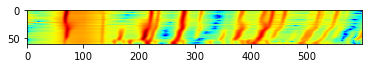

In [193]:
plt.imshow(np.log(1 + bgsubbed), cmap = 'jet')

In [156]:
from matplotlib.widgets import Slider
from pylab import *

1804.4604069055465

In [174]:
# bad rows: 50, ...
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(i):
#     plt.plot(patterns[i], label = 'raw')
    plt.plot(bgsubbed[i], label = 'curve fit subtraction')
    plt.legend()
    plt.grid()

interactive_plot = interactive(f, i=(0, 60), step = 1)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=30, description='i', max=60), Output(layout=Layout(height='350px'))), _d…

In [16]:
bgsubbed = np.vstack(bgsubbed)

In [194]:
with open('data/yijin_cheb_bgsub.npy', 'wb') as f:
    np.save(f, bgsubbed)

In [19]:
ls -lt data | head

total 568
-rw-r--r--    1 ollie  staff  287168 Sep  7 07:57 yijin_cheb_bgsub.npy
drwxr-xr-x    4 ollie  staff     128 Jun  7 22:47 cubic_tetra_simulated_no_agg/
drwxr-xr-x    4 ollie  staff     128 May 18 13:18 cubic_tetra_simulated_.9_1.2_3_peakheight_15/
drwxr-xr-x    4 ollie  staff     128 May 17 22:57 cubic_tetra_simulated_.9_1.2_2/
drwxr-xr-x    4 ollie  staff     128 May 17 22:29 cubic_tetra_simulated_.9_1.3/
drwxr-xr-x    4 ollie  staff     128 May 17 21:35 cubic_tetra_simulated_.9_1.2/
drwxr-xr-x    4 ollie  staff     128 May 17 19:52 cubic_tetra_simulated_logscaled_.9_1.2/
drwxr-xr-x    4 ollie  staff     128 May 17 19:33 cubic_tetra_simulated_logscaled_.9_1.3/
drwxr-xr-x    4 ollie  staff     128 May 17 16:46 cubic_tetra_simulated_logscaled/


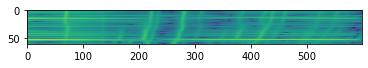

In [15]:
plt.imshow(np.log(1 + np.vstack(bgsubbed)))

In [15]:
ls data

$inst12_Cu3Bi4V6_12_n_neighbor_/
$inst12_Cu3Bi4V6_4_n_neighbor_/
$inst12_Cu3Bi4V6_5_n_neighbor_/
$inst12_Cu3Bi4V6_8_n_neighbor_/
100_member/
AlLiFe_0980/
AlLiFe_0992/
AlLiFe_09927_100p_aug/
AlLiFe_09927_100p_aug_8pshift/
AlLiFe_09927_100p_aug_8pshift_log/
AlLiFe_0995/
AlLiFe_0995_100p/
CoNiSn_shift/
CoNiSn_shift_faces/
CoNiSn_shift_faces_500epoch_biased/
CoNiSn_shift_faces_500epoch_uniform/
CoNiSn_shift_faces_600epoch/
CoNiSn_shift_faces_600epoch_biased/
CoNiSn_shift_faces_600epoch_uniform/
CoNi_shift_2/
CoNi_shift_2_1/
CoNi_shift_extended/
CoNi_shift_extended_2/
CoNi_shift_grouped/
CoNi_shift_grouped_sliding/
CoNi_shift_p0/
CoNi_shift_p1/
CoNi_shift_p8/
CoNi_shift_small/
CoNi_sim_wafer/
CoNi_sim_wafer_aug11/
CoNi_sim_wafer_aug15/
CoNi_sim_wafer_aug_40/
CoNi_sliding_40_20/
KMO/
Ni_cubic_to_tetra/
TiNiSn/
cubic_tetra_simulated_.9_1.2/
cubic_tetra_simulated_.9_1.2_2/
cubic_tetra_simulated_.9_1.2_3_peakheight_15/
cubic_tetra_simulated_.9_1.3/
cubic_tetra_simulated_logscaled/
cubic_tetra_s

NameError: name 'suby' is not defined

> <ipython-input-71-b690963d2db8>(2)<module>()
      1 plt.plot(patterns[0])
----> 2 plt.plot(suby)
      3 plt.plot(patterns[0] - suby[1:-1])
      4 plt.grid()

ipdb> c


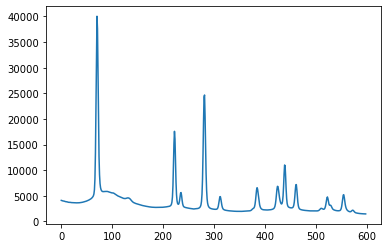

In [71]:
plt.plot(patterns[0])
plt.plot(suby)
plt.plot(patterns[0] - suby[1:-1])
plt.grid()

In [11]:
len(patterns[0])

598

In [33]:
np.arange(600)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [28]:
%pdb

Automatic pdb calling has been turned ON


In [23]:
len(patterns[0])

598

In [18]:
subx


NameError: name 'subx' is not defined

> <ipython-input-18-50b8e3182220>(1)<module>()
----> 1 subx

ipdb> c
